# Sampling with q-space geodesic ODE Solver

In [2]:
## import libararies
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys
import copy

from torch_scatter import scatter_add

from lst_interp import *
import tqdm

import matplotlib.pyplot as plt
# import seaborn as sns

import sys
sys.path.append("/home/share/DATA/NeuralOpt/Interpolations/Geodesic_interp")
# from get_geodesic_energy import get_rijlist_and_re, compute_wij, morse_scaler
from get_geodesic_energy import morse_scaler, ATOMIC_RADIUS

In [3]:
## Experiment setting : random seed, precision, device
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    return
set_seed(0)
torch.set_default_dtype(torch.float64)
torch.set_num_threads(4)

In [4]:
class SamplingParams:
    def __init__(
        self,
        sampling_type,
        c=0.1,
        beta_std=0.125,
        sigma_max=1e-1,
        sigma_min=1e-7,
        sigma1_correction=1e-7,
    ):
        assert sampling_type in ["bell-shaped", "linear", "constant"]
        self.sampling_type = sampling_type
        print(f"Debug: sampling_type = {sampling_type}")

        if sampling_type in ["linear", "constant"]:
            # recommend c=0.1 for "linear", c=np.sqrt(0.1) for "constant"
            self.c = c
            self.sigma_min = sigma_min
            self.sigma_1 = self.sigma_square(1.0)
            self.sigma_0 = self.sigma_square(0.0)
            print(f"Debug: self.c = {self.c}")
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        elif sampling_type == "bell-shaped":
            self.sigma_linear_coef = 0.0
            self.beta_std = beta_std
            self.sigma_max = sigma_max
            if sigma_min is None:
                self.sigma_min = sigma_max * 5e-3
            else:
                self.sigma_min = sigma_min
            self.normalizer = 1 / (beta_std * np.sqrt(2 * np.pi))

            self.sigma_1 = self.sigma_square(1.0) + sigma1_correction
            self.sigma_0 = self.sigma_square(0.0)
            # print(self.sigma_1, self.sigma_0)
            print("Debug: std_beta, sigma_max, sigma_min = ", std_beta, sigma_max, sigma_min)
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        else:
            raise NotImplementedError
        return

    def beta(self, t):
        if self.sampling_type == "linear":
            b = self.c * 2 * t
        elif self.sampling_type == "constant":
            b = self.c**2 * torch.ones_like(t)
        elif self.sampling_type == "bell-shaped":
            if isinstance(t, torch.Tensor):
                b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            else:
                b = np.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            b = b * self.normalizer * self.sigma_max
            b += self.sigma_linear_coef
        else:
            raise NotImplementedError
        return b

    def sigma_square(self, t):
        if self.sampling_type == "linear":
            # s_sq = self.c * t**2 + 1e-4
            s_sq = self.c * t**2 + self.sigma_min
        elif self.sampling_type == "constant":
            # s_sq = self.c**2 * t + 1e-3
            s_sq = self.c**2 * t + self.sigma_min
        elif self.sampling_type == "bell-shaped":
            erf_scaler = self.sigma_max / 2 # / (self.beta_std * np.sqrt(8) * 2)
            if isinstance(t, torch.Tensor):
                s_sq = erf_scaler * (1 + torch.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
            else:
                s_sq = erf_scaler * (1 + scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
        else:
            raise NotImplementedError
        return s_sq
        
    def SNR(self, t):
        return self.sigma_square(t) / self.sigma_1

Debug: sampling_type = bell-shaped
Debug: std_beta, sigma_max, sigma_min =  0.125 0.001 1e-06
Debug: sigma_1, sigma_0 =  0.0010019466575163336 2e-06


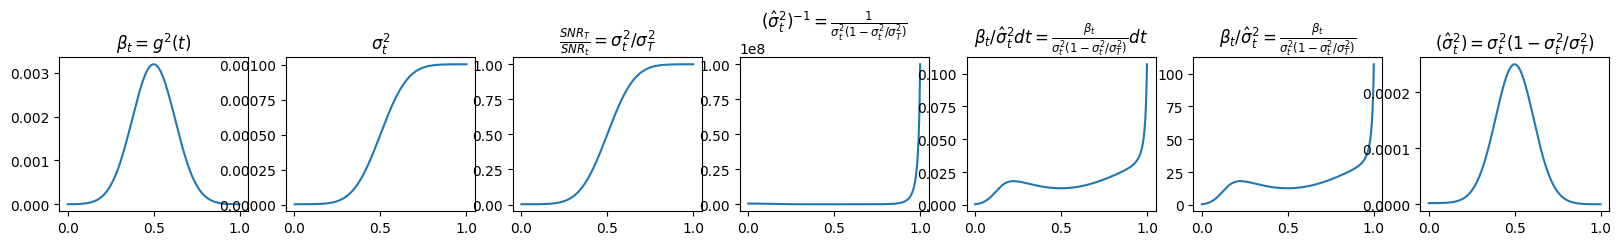

In [5]:
## Set sampling parameters

sampling_type = ["bell-shaped", "linear", "constant"][0]

if sampling_type in ["linear", "constant"]:
    # for linear and square sampling
    c = 0.1
    sigma_min = 1e-7
    sigma_max = 0.1
    std_beta = None
    sigma1_correction = None
else:
    # bell-shaped sampling
    c = 0.1
    # std_beta = 0.125
    std_beta = 0.125
    # sigma_max = 0.10
    sigma_max = 0.001
    sigma_min = 1e-6
    sigma1_correction = 1e-8


params = SamplingParams(
    sampling_type=sampling_type,
    c=c,
    beta_std=std_beta,
    sigma_max=sigma_max,
    sigma_min=sigma_min,
    sigma1_correction=sigma1_correction,
    )

## t samples
num_time_steps = 1000
# t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
t = torch.linspace(0, 1, num_time_steps + 1)[1:]
# t = torch.cat(
#     (torch.linspace(0, 0.5, int(num_time_steps * 0.5)), torch.linspace(0.5, 1, int(num_time_steps * 0.5))),
#     dim=0,
# )
# dt = 
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)


## plot
fig, axs = plt.subplots(1, 7, figsize=(20, 2))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 10})  # Set the global font size to 12
axs = axs.flatten()

ax = axs[0];ax.plot(t, betas);ax.set_title(r"$\beta_t = g^2(t)$")
ax = axs[1];ax.plot(t, sigma_square);ax.set_title("$\sigma_{t}^{2}$")
ax = axs[2];ax.plot(t, SNRTt);ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")
ax = axs[3];ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 / sigma_square / (1 - SNRTt)))
ax = axs[4];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * 1 / len(betas))
ax = axs[5];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)))
ax = axs[6];ax.set_title(r"$(\hat{\sigma}_t^2)={\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 * sigma_square * (1 - SNRTt)))

In [6]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))

In [7]:
## wrapper class to save atoms object

class Wrapper:
    def __init__(self, atoms_0, atoms_T, q_type="DM", alpha=1.7, beta=0.01, gamma=0.01, using_jacobian=True, svd_tol=1e-4):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type
        self.svd_tol = svd_tol
        self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0
        self.using_jacobian = using_jacobian
        return


    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def calc_jacobian(self, pos, q_type):
        # pos = Tensor, (N, 3)
        edge_index, edge_length = self.pos_to_dist(pos)
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        jacobian = []
        for i_idx in range(len(pos)):
            j_idx = list(range(len(pos)))
            j_idx.remove(i_idx)
            j_idx = torch.LongTensor(j_idx)

            j_mask = torch.any(edge_index == i_idx, axis=0)
            dd_dx = torch.zeros(size=(len(edge_length), 3))
            dq_dx = torch.zeros(size=(len(edge_length), 3))
            pos_i = pos[i_idx].reshape(1, -1)
            pos_j = pos[j_idx]

            dist = distance[j_mask].reshape(-1, 1)
            dd_dx[j_mask] += (pos_i - pos_j) / dist

            if q_type == "DM":
                jacobian.append(dd_dx.T)

            elif q_type == "morse":
                dq_dd = - (self.alpha / distance_e[j_mask]) * np.exp(-self.alpha * (distance[j_mask] - distance_e[j_mask]) / distance_e[j_mask])
                dq_dd -= self.beta * distance_e[j_mask] / (distance[j_mask] ** 2)
                dq_dx[j_mask] += dd_dx[j_mask] * dq_dd.reshape(-1, 1)
                jacobian.append(dq_dx.T)
                
            elif q_type == "morese+DM":
                raise NotImplementedError

        return torch.cat(jacobian, dim=0)
    
    def calc_distance_hessian(self, pos, edge_index, distance):
        N = len(pos)
        K = len(edge_index)
        hessian = torch.zeros(size=(K, 3 * N, 3 * N))
        for k, (ij, d_ij) in enumerate(zip(edge_index, distance)):
            i, j = ij
            pos_i, pos_j = pos[i], pos[j]

            # calculate hessian related to i, j atoms
            d_pos = pos_i - pos_j
            hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ij /= d_ij ** 3
            hess_ij -= torch.eye(3) / d_ij
            
            # calculate hessian related to i, i atoms
            hess_ii = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ii /= - d_ij ** 3
            hess_ii += torch.eye(3) / d_ij
            
            # hess_ii = hess_jj
            hess_jj = hess_ii

            hessian[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
            hessian[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_jj
            hessian[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
            hessian[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
            
        return hessian
    
    def calc_hessian(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
            
        edge_index, edge_length = self.pos_to_dist(pos)
        edge_index = edge_index.T
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        hessian = self.calc_distance_hessian(pos, edge_index, distance)
        
        if q_type == "DM":
            return hessian
        
        elif q_type == "morse":
            dq_dd = - self.alpha / distance_e * np.exp(-self.alpha * (distance - distance_e) / distance_e)
            dq_dd -= self.beta * distance_e / (distance ** 2)
            hessian_q = hessian * dq_dd.reshape(-1, 1, 1)
            
            for k, (ij, d_ij, de_ij) in enumerate(zip(edge_index, distance, distance_e)):
                i, j = ij
                pos_i, pos_j = pos[i], pos[j]
                # calculate hessian related to i, j atoms
                d_pos = pos_i - pos_j
                hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
                hess_ij /= - d_ij ** 2
                coeff = self.alpha ** 2 / de_ij ** 2 * np.exp(-self.alpha * (d_ij - de_ij) / de_ij)  + 2 * self.beta * de_ij / (d_ij ** 3)
                hess_ij *= coeff

                # calculate hessian related to i, i atoms
                hess_ii = - hess_ij
                
                hessian_q[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
                hessian_q[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_ii
                hessian_q[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
                hessian_q[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
                
            return hessian_q
        
        elif q_type == "morese+DM":
            raise NotImplementedError
        return 
             
    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.using_jacobian:
            jacobian = self.calc_jacobian(pos, q_type=self.q_type)
            
            score_pos = jacobian @ score_d.reshape(-1, 1)
            return score_pos.reshape(-1, 3)
            
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "morse+DM":
            edge_length = torch.Tensor(pdist(pos))
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr += self.gamma / edge_length
            dd_dr = dd_dr.reshape(-1, 1)
            score_d *= self.scaler_factor
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
        if q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            # print(wij, type(wij))
            # length = torch.Tensor(wij)
            length = wij
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                                  using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
            dx = - 1.0 * reverse_score_ * dt + dw
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index, d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                # every displacement is first calculated on the q-space, and then transformed to the Cartesian space
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw

                dx = self.eq_transform(dd, x_t, index, d_t)
            
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw   
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                            using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dx = - 0.5 * reverse_score_ * dt
            print(f"Debug ({t:0.3f}): \n\t1) diff norm and dx norm {diff.norm():0.4f}, {dx.norm():0.6f}")
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index ,d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                dx = self.eq_transform(dd, x_t, index, d_t)                
                # Want to check why eq-transform does not work well
                diff_d = diff
                diff_x = self.eq_transform(diff_d, x_t, index, d_t)
                print(f"Debug ({t:0.3f}): \n\t1) diff-d norm and diff-x norm {diff_d.norm():0.4f}, {diff_x.norm():0.4f} \n\t2) dd-norm and dx-norm {dd.norm():0.6f}, {dx.norm():0.6f}")
                print(f"\t3) dx-norm/dd-norm {dx.norm()/dd.norm():0.6f}")
                
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                print(f"debug ] time : {t:0.3f}")
                print(f"debug ] diff.norm() : {diff.norm()}")
                print(f"debug ] dd.norm() : {dd.norm()}")
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                print(f"debug ] dx.norm() : {dx.norm()}")
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_score(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

        # calc difference
        diff = mu_hat - x_t

        # calc_score    
        coeff =  1 / (sigma_t_hat_square) * beta_t
        score = diff * coeff
        
        # for debug
        if self.q_type == "DM":
        # if self.q_type in ["DM", "morse"]: # debugging # calculate err corresponding the metric
            _, d_T = self.pos_to_dist(x_T)
            _, d_t = self.pos_to_dist(x_t)
            _, d_0 = self.pos_to_dist(x_0)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
            v1 = (d_mu_hat - d_t).abs().mean()
            # v2 = (d_mu_hat - d_T).abs().mean()
            v2 = (d_0 - d_t).abs().mean()
            v3 = (mu_hat - x_t.numpy()).abs().mean()
            v4 = (mu_hat - x_T.numpy()).abs().mean()
        # elif self.q_type == "morse":
        elif self.q_type in ["morse", "morse+DM", "Cartesian"]:
            version = "DMAE"
            # version = "Morse-RMSD"
            if version == "DMAE":
                d_T = torch.Tensor(pdist(x_T))
                d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
                d_t = torch.Tensor(pdist(x_t))
                d_0 = torch.Tensor(pdist(x_0))
                v1 = (d_mu_hat - d_t).abs().mean()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).abs().mean()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
            else:
                _, d_T = self.pos_to_dist(x_T)
                _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
                _, d_t = self.pos_to_dist(x_t)
                _, d_0 = self.pos_to_dist(x_0)
                v1 = (d_mu_hat - d_t).norm()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).norm()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
        else:
            raise NotImplementedError
        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return diff, coeff, v1, v2, v3, v4

    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        
        # calc difference
        index, d_t = self.pos_to_dist(x_t)
        diff_d = d_mu_hat - d_t
        diff = diff_d
        coeff =  1 / (sigma_t_hat_square) * beta_t

        # for debugging
        d_T = torch.Tensor(pdist(x_T))
        d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
        d_t = torch.Tensor(pdist(x_t))
        d_0 = torch.Tensor(pdist(x_0))
        v_loss_mae = (d_mu_hat - d_t).abs().mean()  # DMAE
        v_acc_mae = (d_0 - d_t).abs().mean()  # DMAE

        original_q_type = copy.deepcopy(self.q_type)
        self.q_type = "morse"
        _, d_T = self.pos_to_dist(x_T)
        _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
        _, d_t = self.pos_to_dist(x_t)
        _, d_0 = self.pos_to_dist(x_0)
        v_loss_norm = (d_mu_hat - d_t).norm()  # q-norm
        v_acc_norm = (d_0 - d_t).norm()  # q-norm
        self.q_type = original_q_type
        

        if verbose:
            print(f"{t:0.3f}\t{v_loss_mae:0.4f}\t\t{v_acc_mae:0.4f}\t\t{v_loss_norm:0.4f}\t\t{v_acc_norm:0.4f}\t")
        return diff, coeff, v_loss_mae, v_acc_mae, v_loss_norm, v_acc_norm
    
    def exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10):
        
        t = torch.linspace(0, 1, num_iter + 1)[:-1]
        dt = t[1] - t[0]
        
        def one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=False):
            hess = wrapper.calc_hessian(x.reshape(-1, 3), q_type=q_type)
            jacob = wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T
            
            J, J_inv = wrapper.refine_jacobian(jacob)
            JG = J_inv.T
            
            if refine_xdot:
                x_dot = J_inv @ J @ x_dot
            
            christoffel = torch.einsum("mij, mk->kij", hess, JG)
            x_ddot = - torch.einsum("j,kij,i->k", x_dot, christoffel, x_dot)
            # x_ddot and x_dot should be perpendicular 
            q_ddot = J @ x_ddot
            q_dot = J @ x_dot
            # remove q_dot component from q_ddot
            # q_ddot -= (q_ddot * q_dot).sum() * q_dot / (q_dot * q_dot).sum()
            # x_ddot = J_inv @ q_ddot
            
            new_x = x + x_dot * dt
            new_x_dot = x_dot + x_ddot * dt
            
            # dotproduct
            print(f"\t\tdebug: <x_ddot, x_dot> = {(q_ddot * q_dot).sum()}")
            print(f"\t\tdebug: dx norm = {(new_x - x).norm():0.4f}, dx_dot norm = {(new_x_dot - x_dot).norm():0.4f}")
            return new_x, new_x_dot
        
        jacob = self.calc_jacobian(x0, q_type=q_type).T
        J, J_inv = self.refine_jacobian(jacob)
        
        # debugging
        proj_q_dot = J @ J_inv @ q_dot0
        print(f"\tdebug: proj_q_dot norm = {(proj_q_dot - q_dot0).norm()/ q_dot0.norm():0.4f}")
        
        # initialization
        x_dot0 = J_inv @ q_dot0
        x = x0.flatten()
        x_dot = x_dot0
        
        # solve the geodesic ODE iteratively
        for i, t_i in enumerate(t):
            do_refine = i % check_dot_every == 0
            x, x_dot = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine)
        return x.reshape(-1, 3)
    
    
    def svd(self, jacob):
        U, S, Vh = torch.linalg.svd(jacob)
        num_zeros = (S < self.svd_tol).sum()
        dim = len(S) - num_zeros
        S = S[:dim]
        U = U[:, :dim]
        Vh = Vh[:dim, :]
        print(f"\t\t\tdebug: dim = {dim}, num_zeros = {num_zeros}, singular values = {S[-1].item():0.6f} ~ {S[0].item():0.6f}")
        return U, S, Vh

    def refine_jacobian(self, jacob):
        # find non-zero singular values
        U, S, Vh = self.svd(jacob)
        J = U @ torch.diag(S) @ Vh
        J_inv = Vh.T @ torch.diag(1 / S) @ U.T
        return J, J_inv
        

# Singular value check

In [8]:
# load molecules

idx = 10
q_type = "morse"
xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

# load wrapper
gamma = 0.0
alpha, beta = 1.7, 0.01

print(f"Debug: alpha, beta = {alpha}, {beta}")
wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True)

x0 = torch.Tensor(x0.positions)
xT = torch.Tensor(xT.positions)

# compute jacobian
jacob = wrapper.calc_jacobian(xT, q_type=q_type).T

# SVD
U, S, Vh = torch.linalg.svd(jacob)
torch.set_printoptions(precision=14, sci_mode=False)
print(f"non-zero singular values : \n{S[:-6]}")
print(f"zero singluar values : \n{S[-6:]}")
print(f"condition number : \n{S[0] / S[-7]}")


Debug: alpha, beta = 1.7, 0.01
non-zero singular values : 
tensor([    2.49922942582707,     2.39228617621461,     2.24243371699786,
            2.12415165428169,     1.97740052906631,     1.87609534502494,
            1.48420585874066,     1.40828081145321,     1.32022371033849,
            0.93232327941578,     0.70814290739738,     0.62276418573151,
            0.51117154298952,     0.36048177947255,     0.23074538740644,
            0.09671475287566,     0.06741390700414,     0.03725127382749,
            0.02145573721136,     0.01290652352606,     0.00103524289502])
zero singluar values : 
tensor([    0.00000000000000,     0.00000000000000,     0.00000000000000,
            0.00000000000000,     0.00000000000000,     0.00000000000000])
condition number : 
2414.147866030631


# Move from $q_0$ to $q_T$ using difference vector as score.

In [9]:
# compute q of x0 and xT
q0 = wrapper.pos_to_dist(x0)[1]
qT = wrapper.pos_to_dist(xT)[1]

# compute q_dot0, approximate it with qT - q0
q_dot0 = (qT - q0)
print(f"norm of q_dot0 : {torch.linalg.norm(q_dot0):0.4f}")
x = wrapper.exponential_ode_solver(x0, q_dot0, q_type=q_type, num_iter=100, check_dot_every=10)

def rmsd(x):
    return (x ** 2).sum(-1).mean().sqrt()


# Expect that x is close to xT
print("\nRMSD")
print(f"RMSD btw xT, x : {rmsd((xT - x).reshape(-1, 3)).item():0.4f}")
print(f"RMSD btw x0, x : {rmsd((x0 - x).reshape(-1, 3)).item():0.4f}")
print(f"RMSD btw xT, x0 : {rmsd((xT - x0).reshape(-1, 3)).item():0.4f}")

q = wrapper.pos_to_dist(x)[1]
print("\nq")
print(f"q-norm btw qT, q : {torch.linalg.norm(qT - q).item():0.4f}")
print(f"q-norm btw q0, q : {torch.linalg.norm(q0 - q).item():0.4f}")
print(f"q-norm btw qT, q0 : {torch.linalg.norm(qT - q0).item():0.4f}")

d0 = torch.Tensor(pdist(x0))
d = torch.Tensor(pdist(x))
dT = torch.Tensor(pdist(xT))
print("\nd")
print(f"DMAE btw dT, d : {torch.abs(dT - d).mean().item():0.4f}")
print(f"DMAE btw d0, d : {torch.abs(d0 - d).mean().item():0.4f}")
print(f"DMAE btw dT, d0 : {torch.abs(dT - d0).mean().item():0.4f}")

norm of q_dot0 : 0.3026
			debug: dim = 21, num_zeros = 6, singular values = 0.000525 ~ 2.613170
	debug: proj_q_dot norm = 0.0188
			debug: dim = 21, num_zeros = 6, singular values = 0.000525 ~ 2.613170
		debug: <x_ddot, x_dot> = 0.006084203169138963
		debug: dx norm = 0.0029, dx_dot norm = 0.0235
			debug: dim = 21, num_zeros = 6, singular values = 0.000585 ~ 2.610746
		debug: <x_ddot, x_dot> = 0.005973570293911734
		debug: dx norm = 0.0028, dx_dot norm = 0.0159
			debug: dim = 21, num_zeros = 6, singular values = 0.000637 ~ 2.608328
		debug: <x_ddot, x_dot> = 0.005891372635326018
		debug: dx norm = 0.0028, dx_dot norm = 0.0117
			debug: dim = 21, num_zeros = 6, singular values = 0.000681 ~ 2.605918
		debug: <x_ddot, x_dot> = 0.005829723092333518
		debug: dx norm = 0.0028, dx_dot norm = 0.0091
			debug: dim = 21, num_zeros = 6, singular values = 0.000720 ~ 2.603516
		debug: <x_ddot, x_dot> = 0.00578486126793327
		debug: dx norm = 0.0028, dx_dot norm = 0.0074
			debug: dim = 21, num_ze

# Main experiment

Sampling with geodesic ODE solver

In [14]:
def experiment1(
    idx,
    sampling_type,
    coord_type,
    h_coeff=0.0,
    num_time_steps=200,
    verbose=False,
    plot=True,
    q_type="morse",
    sampling_test=1,
    atoms_0=atoms_0,
    atoms_T=atoms_T,
    inner_iteration=3,
    outer_iteration=None,
    svd_tol=1e-4,
):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]
    
    print(f"idx, gt_idx: {idx}, {gt_idx}")
    gamma = 0.0
    alpha, beta = 1.7, 0.01
    
    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True, svd_tol=svd_tol)

    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())

    margin = 0.001
    # t = torch.linspace(0 + margin, 1 - 10 * margin, num_time_steps + 1)[:-1]
    t = torch.linspace(0 + margin, 0.9, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []

    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
    # for idx, i in tqdm.tqdm(enumerate(torch.flip(t, dims=(0,))), total=len(t)):
        if sampling_type == "ode":
            x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose, sampling_test=sampling_test, inner_iteration=inner_iteration)
        else: # sde
            x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose, sampling_test=sampling_test, inner_iteration=inner_iteration)

        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)
        
        if idx == outer_iteration: break

    return reverse_traj, v1s, v2s, v3s, v4s


def plot_traj(v, label="", ylabel=""): # r"||$\hat{d}_t - d_t$||"
    plt.plot(v, label=label)
    plt.xlabel(r"time step", fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    return

q_type = morse
idx, gt_idx: 0, 4
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.6818
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.865244055262797e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.8918726737289015e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.9116323188984955e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0007
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.924110909508202e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0007
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.929183275736731e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0007
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.6375
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.57339976144083e-06
		debug: dx norm = 0.0157, dx_dot norm = 0.0011
			debug: dim =

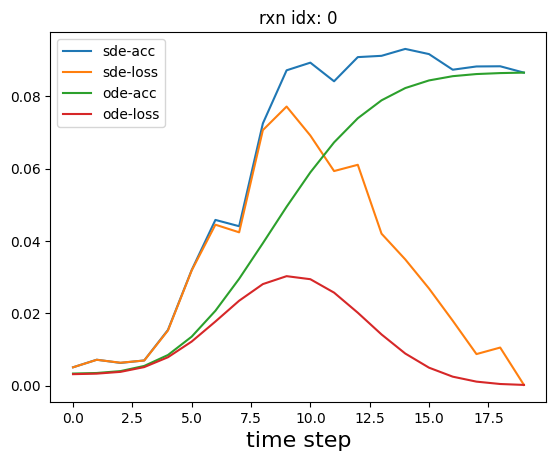

idx, gt_idx: 1, 6
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.6625
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.186195028037587e-06
		debug: dx norm = 0.0193, dx_dot norm = 0.0011
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.131240817122638e-06
		debug: dx norm = 0.0193, dx_dot norm = 0.0011
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.0762092034430224e-06
		debug: dx norm = 0.0193, dx_dot norm = 0.0011
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.021490142153111e-06
		debug: dx norm = 0.0192, dx_dot norm = 0.0011
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.967216157216581e-06
		debug: dx norm = 0.0191, dx_dot norm = 0.0011
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.6170
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.00010394926382329501
		debug: dx norm = 0.0281, dx_dot norm = 0.0083
			debug: dim = 33, num_zero

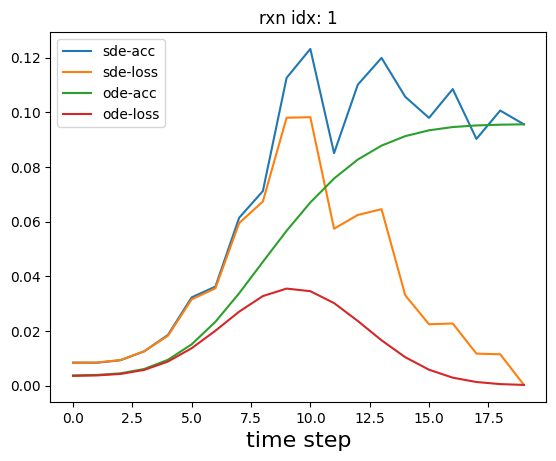

idx, gt_idx: 2, 8
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.8323
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.600926709001053e-07
		debug: dx norm = 0.0087, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.854486669621635e-07
		debug: dx norm = 0.0087, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -5.108710114441566e-07
		debug: dx norm = 0.0087, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -5.363374026869745e-07
		debug: dx norm = 0.0088, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -5.618659211302301e-07
		debug: dx norm = 0.0088, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.6836
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -9.454784192693717e-06
		debug: dx norm = 0.0172, dx_dot norm = 0.0009
			debug: dim = 42, num_z

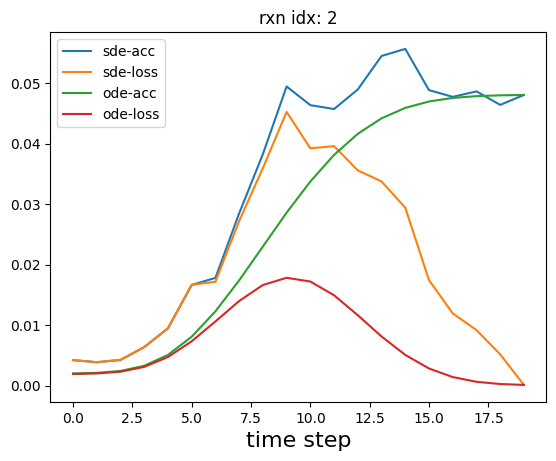

idx, gt_idx: 3, 9
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.8290
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.3233143219748823e-06
		debug: dx norm = 0.0106, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.370869512722351e-06
		debug: dx norm = 0.0106, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.4181003125553746e-06
		debug: dx norm = 0.0106, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.4649393881297833e-06
		debug: dx norm = 0.0106, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.5114478103154396e-06
		debug: dx norm = 0.0106, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.6725
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.4619701367356075e-05
		debug: dx norm = 0.0218, dx_dot norm = 0.0027
			debug: dim = 42, 

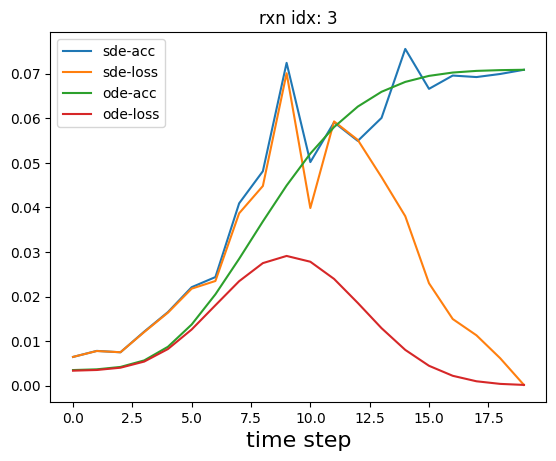

idx, gt_idx: 4, 10
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.8120
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.8233703330348865e-06
		debug: dx norm = 0.0138, dx_dot norm = 0.0014
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.685971695552992e-06
		debug: dx norm = 0.0136, dx_dot norm = 0.0014
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.5494469779042714e-06
		debug: dx norm = 0.0134, dx_dot norm = 0.0013
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.414328904540187e-06
		debug: dx norm = 0.0132, dx_dot norm = 0.0013
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.281379271565785e-06
		debug: dx norm = 0.0130, dx_dot norm = 0.0012
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.6919
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.1815849768212885e-05
		debug: dx norm = 0.0204, dx_dot norm = 0.0024
			debug: dim = 42, num_ze

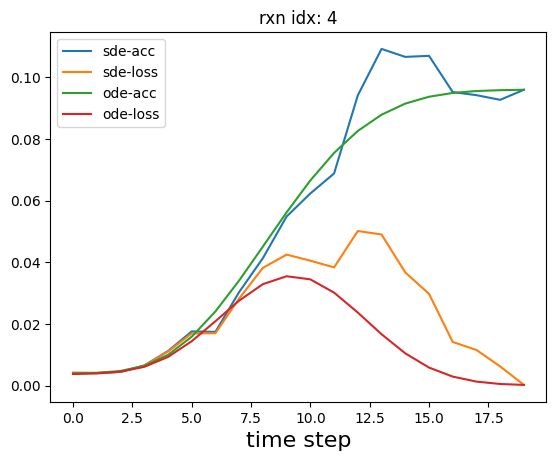

idx, gt_idx: 5, 11
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.8260
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -7.440335378111686e-09
		debug: dx norm = 0.0106, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.418207043450284e-08
		debug: dx norm = 0.0106, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.087256304751364e-08
		debug: dx norm = 0.0106, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.1746680979203168e-07
		debug: dx norm = 0.0106, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.5400114459035433e-07
		debug: dx norm = 0.0106, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7046
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.4153452909583442e-05
		debug: dx norm = 0.0172, dx_dot norm = 0.0009
			debug: dim = 42, n

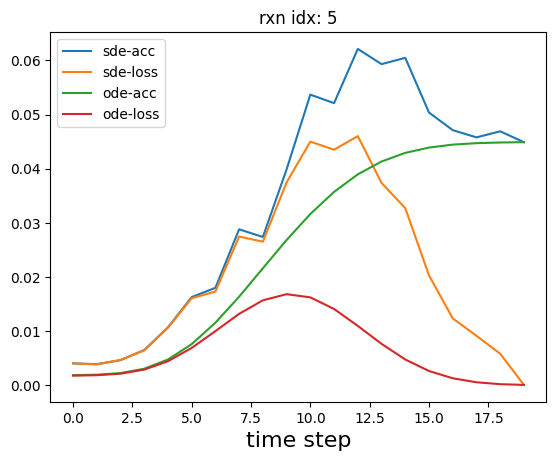

idx, gt_idx: 6, 12
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.7126
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.00010817725999587092
		debug: dx norm = 0.0597, dx_dot norm = 0.6823
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.022742154402807864
		debug: dx norm = 0.0790, dx_dot norm = 0.3978
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.017380997328380225
		debug: dx norm = 0.1580, dx_dot norm = 4.4975
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 33.09778265222077
		debug: dx norm = 0.7421, dx_dot norm = 14.4793
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -1034.139955436408
		debug: dx norm = 3.6376, dx_dot norm = 28.2049
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.4817
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 2542.688423055753
		debug: dx norm = 32.5334, dx_dot norm = 5095.0459
			debug: dim = 12, num_zeros = 15


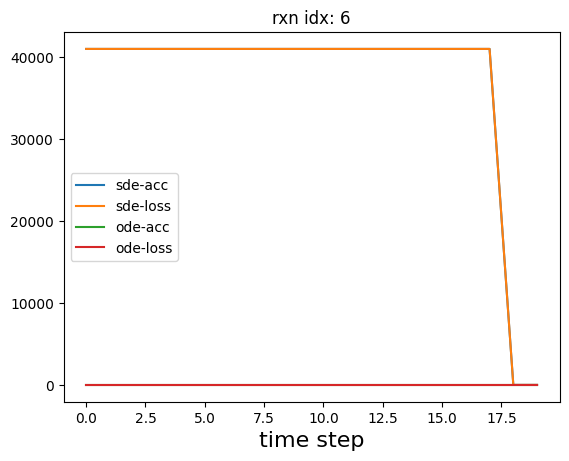

idx, gt_idx: 7, 14
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.7131
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.00011206125455987455
		debug: dx norm = 0.0595, dx_dot norm = 0.6820
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.022684256923081673
		debug: dx norm = 0.0787, dx_dot norm = 0.3973
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.01755392087459254
		debug: dx norm = 0.1578, dx_dot norm = 4.4571
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 32.085582239583886
		debug: dx norm = 0.7342, dx_dot norm = 14.1952
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -1093.0205554005881
		debug: dx norm = 3.5730, dx_dot norm = 26.6850
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.4766
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 2154.1369193593696
		debug: dx norm = 30.0147, dx_dot norm = 4384.0551
			debug: dim = 14, num_zeros = 1

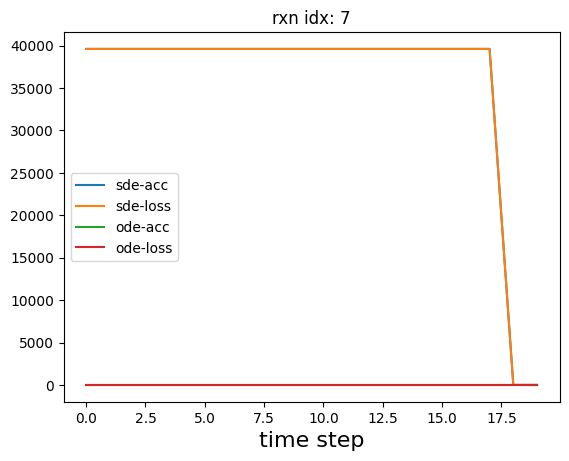

idx, gt_idx: 8, 15
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.6655
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.0003038243395339624
		debug: dx norm = 0.0617, dx_dot norm = 0.2078
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.0018350733620463376
		debug: dx norm = 0.0599, dx_dot norm = 0.5075
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.14993569051393402
		debug: dx norm = 0.1588, dx_dot norm = 4.6848
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 45.92943537369964
		debug: dx norm = 0.7821, dx_dot norm = 13.1535
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -102.71179158121274
		debug: dx norm = 3.4117, dx_dot norm = 37.8706
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.5739
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 832.9581001490467
		debug: dx norm = 25.3813, dx_dot norm = 2678.0824
			debug: dim = 16, num_zeros = 11

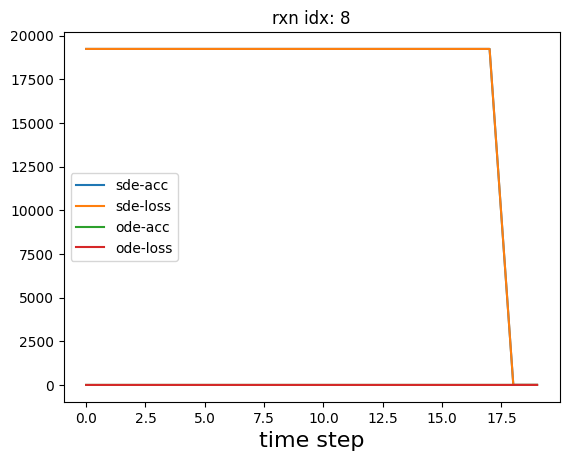

idx, gt_idx: 9, 16
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 15, num_zeros = 12
	debug: proj_q_dot norm = 0.7381
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = 6.973954655707408e-09
		debug: dx norm = 0.0018, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = 7.128557997533744e-09
		debug: dx norm = 0.0018, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = 7.283458135810154e-09
		debug: dx norm = 0.0018, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = 7.438658726115398e-09
		debug: dx norm = 0.0018, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = 7.594155786226654e-09
		debug: dx norm = 0.0018, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
	debug: proj_q_dot norm = 0.6728
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -4.143255573238037e-06
		debug: dx norm = 0.0044, dx_dot norm = 0.0001
			debug: dim = 15, n

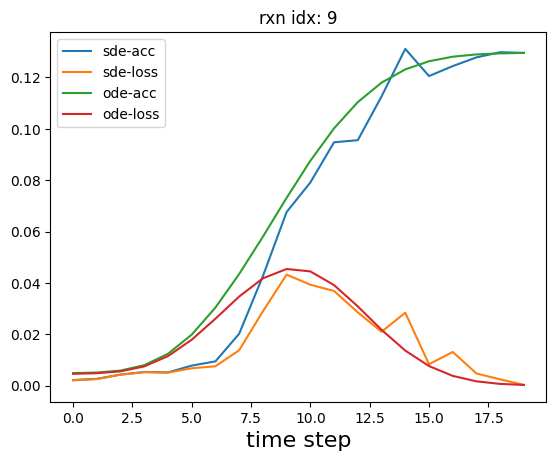

idx, gt_idx: 10, 17
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 15, num_zeros = 12
	debug: proj_q_dot norm = 0.7401
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -1.8720685019068626e-08
		debug: dx norm = 0.0015, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -1.861533631213808e-08
		debug: dx norm = 0.0015, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -1.8509990093457518e-08
		debug: dx norm = 0.0015, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -1.8404609541292163e-08
		debug: dx norm = 0.0015, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -1.8299265663712176e-08
		debug: dx norm = 0.0015, dx_dot norm = 0.0000
			debug: dim = 15, num_zeros = 12
	debug: proj_q_dot norm = 0.6303
			debug: dim = 15, num_zeros = 12
		debug: <x_ddot, x_dot> = -4.666263313356553e-07
		debug: dx norm = 0.0038, dx_dot norm = 0.0000
			debug: d

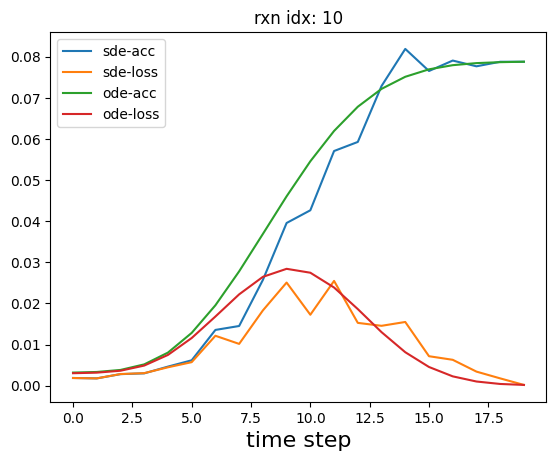

idx, gt_idx: 11, 21
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.5263
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.088153369900681e-05
		debug: dx norm = 0.0853, dx_dot norm = 1.1609
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.3425937326837926
		debug: dx norm = 0.3139, dx_dot norm = 11.0296
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 560.9867299573252
		debug: dx norm = 1.8999, dx_dot norm = 59.5422
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 44398.2201519574
		debug: dx norm = 13.8006, dx_dot norm = 1856.8935
			debug: dim = 19, num_zeros = 8
		debug: <x_ddot, x_dot> = 6301216.5386777725
		debug: dx norm = 383.5196, dx_dot norm = 414360.3893
			debug: dim = 0, num_zeros = 27
	debug: proj_q_dot norm = 1.0000
			debug: dim = 0, num_zeros = 27
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 27
		debug: <x_dd

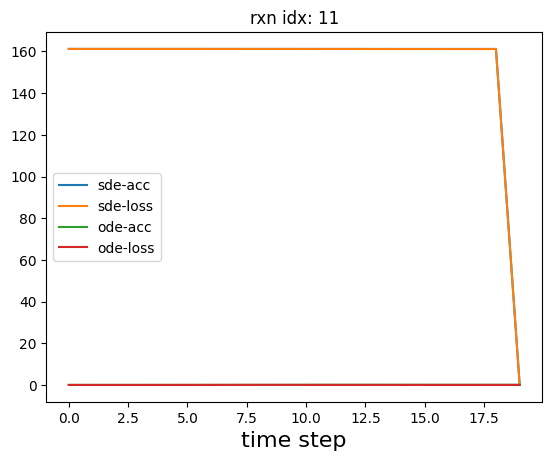

idx, gt_idx: 12, 22
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 21, num_zeros = 6
	debug: proj_q_dot norm = 0.6520
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.026929491236090154
		debug: dx norm = 0.6344, dx_dot norm = 118.6810
			debug: dim = 21, num_zeros = 6
		debug: <x_ddot, x_dot> = -894906.4238314582
		debug: dx norm = 24.2855, dx_dot norm = 3880.5372
			debug: dim = 16, num_zeros = 11
		debug: <x_ddot, x_dot> = -3172189.037319087
		debug: dx norm = 754.0690, dx_dot norm = 6024706.2546
			debug: dim = 0, num_zeros = 27
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 27
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 27
	debug: proj_q_dot norm = 1.0000
			debug: dim = 0, num_zeros = 27
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 27
		debug: <x_ddot, x_dot> = 0.0
		debug: d

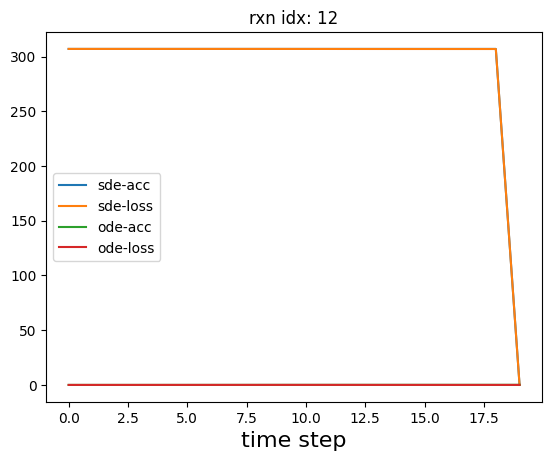

idx, gt_idx: 13, 23
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7779
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.8279278136138487e-07
		debug: dx norm = 0.0097, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.058831258776498e-07
		debug: dx norm = 0.0097, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.28980127535911e-07
		debug: dx norm = 0.0097, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.520536279754364e-07
		debug: dx norm = 0.0097, dx_dot norm = 0.0003
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.751163715218552e-07
		debug: dx norm = 0.0097, dx_dot norm = 0.0003
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7474
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.4955812740188704e-05
		debug: dx norm = 0.0215, dx_dot norm = 0.0027
			debug: dim = 42, num

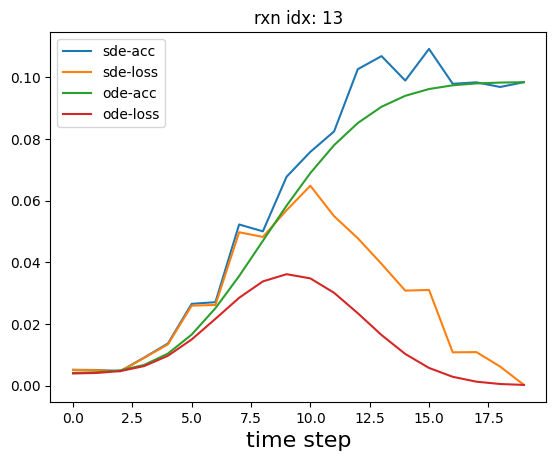

idx, gt_idx: 14, 24
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7739
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.6988618691310267e-06
		debug: dx norm = 0.0197, dx_dot norm = 0.0011
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.917466521782998e-06
		debug: dx norm = 0.0198, dx_dot norm = 0.0011
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.145791543696889e-06
		debug: dx norm = 0.0200, dx_dot norm = 0.0011
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.3839351808721495e-06
		debug: dx norm = 0.0201, dx_dot norm = 0.0011
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.632830777585097e-06
		debug: dx norm = 0.0203, dx_dot norm = 0.0011
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7474
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.7512702107623434e-05
		debug: dx norm = 0.0305, dx_dot norm = 0.0032
			debug: dim = 42, n

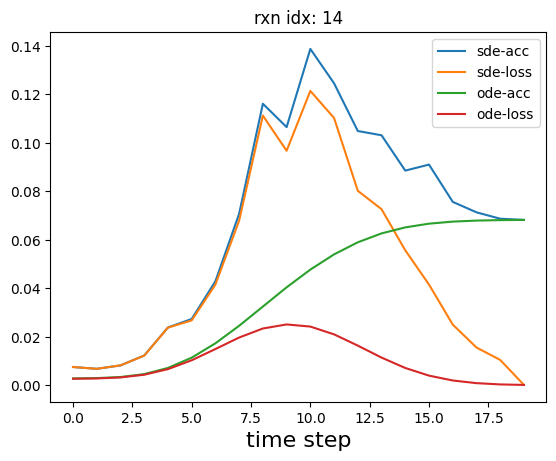

idx, gt_idx: 15, 26
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7676
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.1666179600825035e-06
		debug: dx norm = 0.0151, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.206769509628963e-06
		debug: dx norm = 0.0151, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.2471697918131248e-06
		debug: dx norm = 0.0152, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.2877184489678973e-06
		debug: dx norm = 0.0152, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.3285820381776816e-06
		debug: dx norm = 0.0152, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7633
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.822064348951702e-05
		debug: dx norm = 0.0212, dx_dot norm = 0.0013
			debug: dim = 42, 

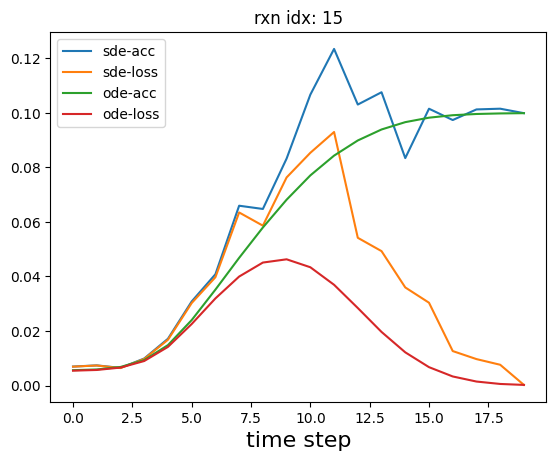

idx, gt_idx: 16, 27
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7624
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.1773870013099822e-05
		debug: dx norm = 0.0121, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.1967709077628335e-05
		debug: dx norm = 0.0122, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.2145222718547321e-05
		debug: dx norm = 0.0122, dx_dot norm = 0.0005
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.2304378666571548e-05
		debug: dx norm = 0.0122, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.2443576995551574e-05
		debug: dx norm = 0.0123, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7480
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.2733495099939971e-05
		debug: dx norm = 0.0177, dx_dot norm = 0.0009
			debug: dim = 42, nu

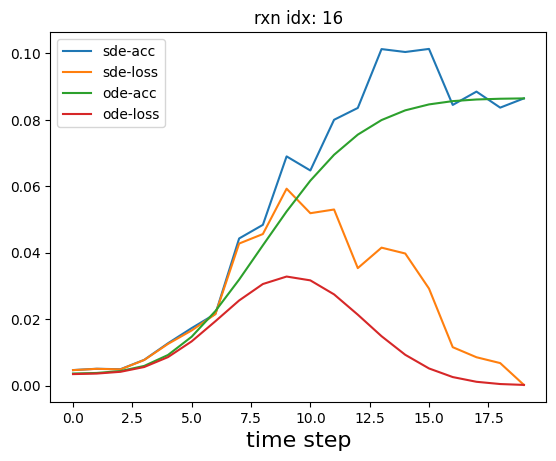

idx, gt_idx: 17, 30
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7672
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.2104285660999553e-06
		debug: dx norm = 0.0089, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.1999594010240645e-06
		debug: dx norm = 0.0089, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.189042578695371e-06
		debug: dx norm = 0.0089, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.177687488064709e-06
		debug: dx norm = 0.0089, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.1659235175770976e-06
		debug: dx norm = 0.0089, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7345
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -3.830453436802778e-06
		debug: dx norm = 0.0157, dx_dot norm = 0.0012
			debug: dim = 42, num_z

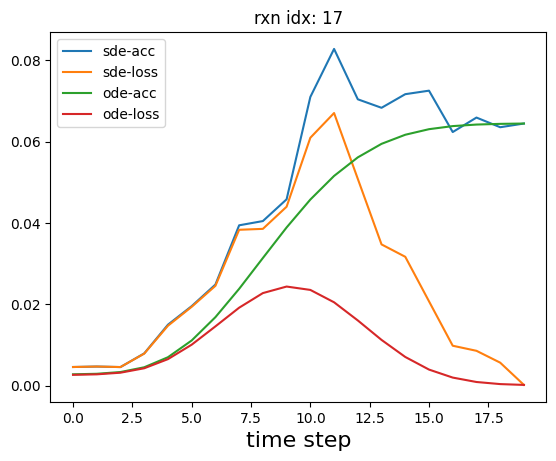

idx, gt_idx: 18, 31
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7585
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.1980232474745057e-06
		debug: dx norm = 0.0121, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.2364727701246306e-06
		debug: dx norm = 0.0121, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.2753631189766336e-06
		debug: dx norm = 0.0122, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.3146515641826198e-06
		debug: dx norm = 0.0122, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.3544128254259565e-06
		debug: dx norm = 0.0123, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7664
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.4689195459139613e-06
		debug: dx norm = 0.0192, dx_dot norm = 0.0010
			debug: dim = 42

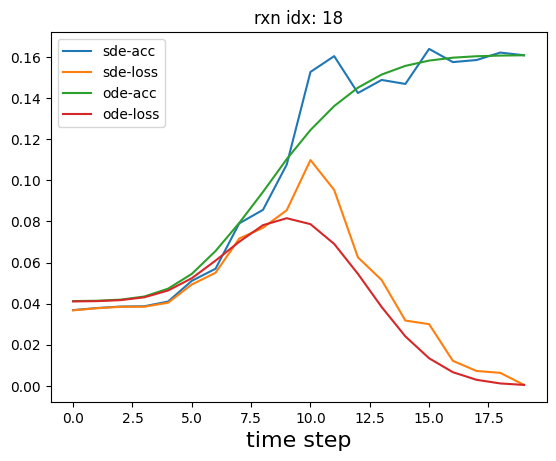

idx, gt_idx: 19, 32
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7665
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.9387330393086004e-06
		debug: dx norm = 0.0102, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.91392944453107e-06
		debug: dx norm = 0.0102, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.8886156506228737e-06
		debug: dx norm = 0.0102, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.862811459176639e-06
		debug: dx norm = 0.0101, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.836524075534568e-06
		debug: dx norm = 0.0101, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7731
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.871800414691671e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0007
			debug: dim = 42, num_zero

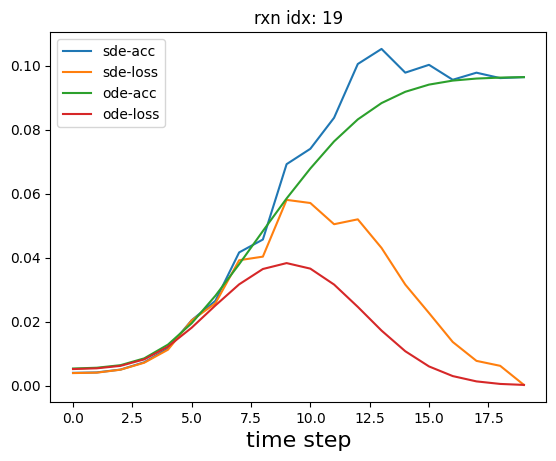

idx, gt_idx: 20, 34
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7908
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.813804772437513e-07
		debug: dx norm = 0.0091, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.667846691449784e-07
		debug: dx norm = 0.0091, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.519659790169411e-07
		debug: dx norm = 0.0091, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.3693466842464648e-07
		debug: dx norm = 0.0091, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.2166801171185124e-07
		debug: dx norm = 0.0091, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7762
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -7.594503653357452e-06
		debug: dx norm = 0.0130, dx_dot norm = 0.0007
			debug: dim = 42, num_ze

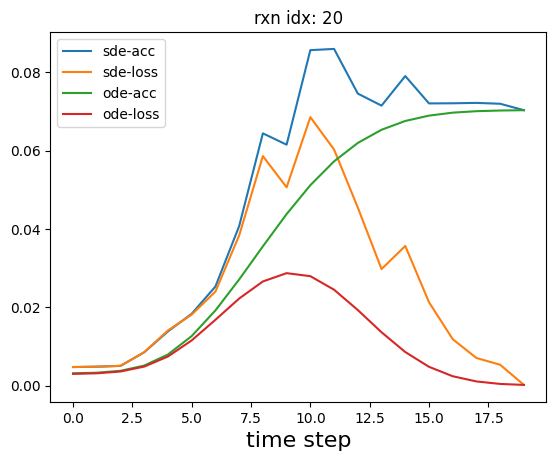

idx, gt_idx: 21, 35
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7876
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.449329795803773e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.4386346142414095e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.427779228591422e-06
		debug: dx norm = 0.0114, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.4167794055452375e-06
		debug: dx norm = 0.0114, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.4056281330195872e-06
		debug: dx norm = 0.0114, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7780
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.4532393576887255e-06
		debug: dx norm = 0.0140, dx_dot norm = 0.0007
			debug: dim = 42, num_z

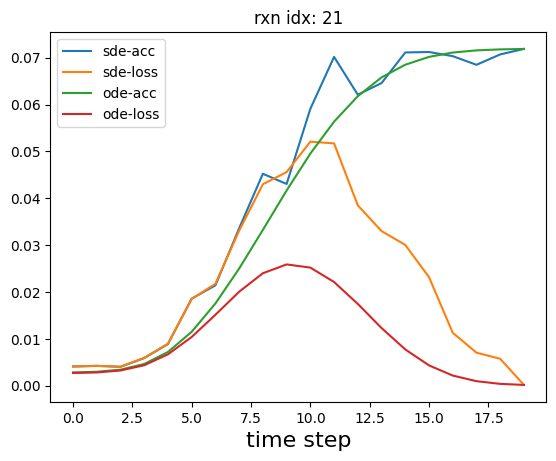

idx, gt_idx: 22, 36
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7773
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.8611336044781677e-05
		debug: dx norm = 0.0135, dx_dot norm = 0.0006
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.8294620564826998e-05
		debug: dx norm = 0.0135, dx_dot norm = 0.0007
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.797262239224178e-05
		debug: dx norm = 0.0134, dx_dot norm = 0.0007
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.7647412157729423e-05
		debug: dx norm = 0.0133, dx_dot norm = 0.0007
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.732128523167533e-05
		debug: dx norm = 0.0133, dx_dot norm = 0.0006
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7626
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.0673011694386864e-05
		debug: dx norm = 0.0201, dx_dot norm = 0.0014
			debug: dim = 42, num_

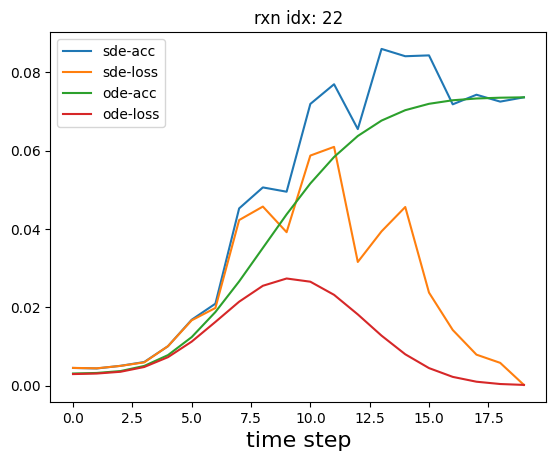

idx, gt_idx: 23, 37
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7699
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.631883817148105e-08
		debug: dx norm = 0.0078, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.2774135629754564e-08
		debug: dx norm = 0.0078, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.9090289171604856e-08
		debug: dx norm = 0.0078, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.5281447448267584e-08
		debug: dx norm = 0.0078, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.1341710088780984e-08
		debug: dx norm = 0.0078, dx_dot norm = 0.0002
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7533
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -9.960086695948656e-08
		debug: dx norm = 0.0192, dx_dot norm = 0.0010
			debug: dim = 42, num_

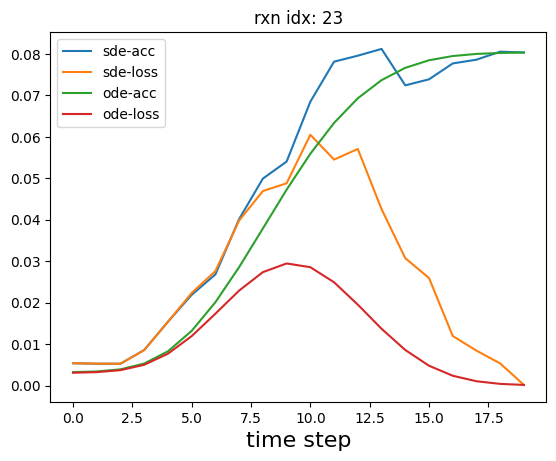

idx, gt_idx: 24, 38
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7933
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.376798201448998e-06
		debug: dx norm = 0.0112, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.4004571420228677e-06
		debug: dx norm = 0.0112, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.4239600984647966e-06
		debug: dx norm = 0.0112, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.447265448893643e-06
		debug: dx norm = 0.0112, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.4704341459402087e-06
		debug: dx norm = 0.0112, dx_dot norm = 0.0004
			debug: dim = 42, num_zeros = 6
	debug: proj_q_dot norm = 0.7406
			debug: dim = 42, num_zeros = 6
		debug: <x_ddot, x_dot> = 9.004486908899515e-06
		debug: dx norm = 0.0213, dx_dot norm = 0.0023
			debug: dim = 42, n

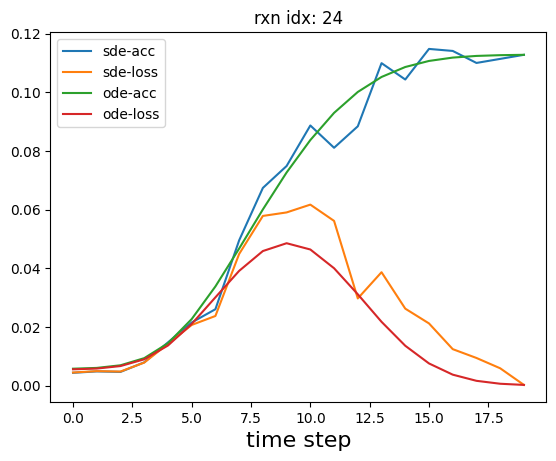

idx, gt_idx: 25, 39
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7499
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.5463189064434954e-05
		debug: dx norm = 0.0178, dx_dot norm = 0.0045
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 4.273496342331827e-05
		debug: dx norm = 0.0172, dx_dot norm = 0.0057
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.918520267575833e-05
		debug: dx norm = 0.0163, dx_dot norm = 0.0060
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.527439178997372e-05
		debug: dx norm = 0.0154, dx_dot norm = 0.0057
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.143536550535146e-05
		debug: dx norm = 0.0145, dx_dot norm = 0.0052
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.6224
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.00010303636048518846
		debug: dx norm = 0.0217, dx_dot norm = 0.0087
			debug: dim = 30, num_ze

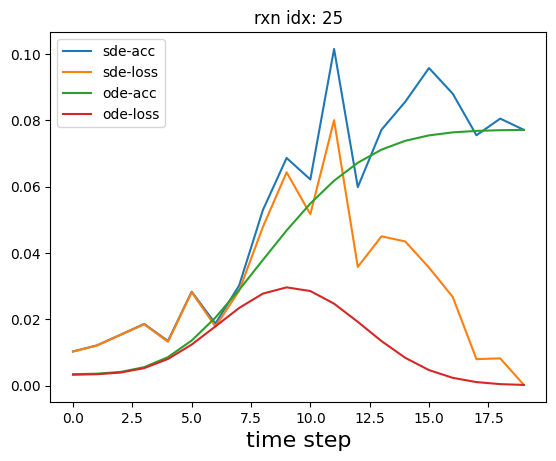

idx, gt_idx: 26, 40
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 28, num_zeros = 8
	debug: proj_q_dot norm = 0.7398
			debug: dim = 28, num_zeros = 8
		debug: <x_ddot, x_dot> = 1.8759881467476558
		debug: dx norm = 4.5597, dx_dot norm = 13521.4627
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 42698208855.3877
		debug: dx norm = 2708.8277, dx_dot norm = 95055642.7676
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 19012746.0599, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
	debug: proj_q_dot norm = 1.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.00

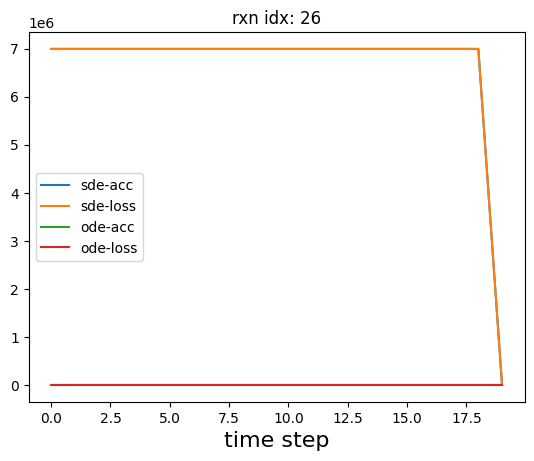

idx, gt_idx: 27, 41
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7315
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.00047256109829234283
		debug: dx norm = 0.1794, dx_dot norm = 1.1702
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.07873248296910172
		debug: dx norm = 0.0900, dx_dot norm = 1.0511
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.26537547895169167
		debug: dx norm = 0.2809, dx_dot norm = 6.8630
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 160.5378222341348
		debug: dx norm = 1.1325, dx_dot norm = 17.2745
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2797.932434040978
		debug: dx norm = 4.4460, dx_dot norm = 125.6212
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.5476
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 51935.363731906014
		debug: dx norm = 165.1935, dx_dot norm = 80776.5818
			debug: dim = 4, num_zeros = 32

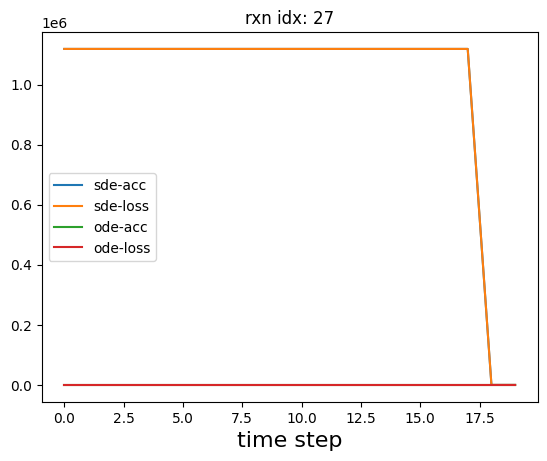

idx, gt_idx: 28, 42
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7267
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.7505773132170834e-05
		debug: dx norm = 0.0207, dx_dot norm = 0.0037
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.7517374609483964e-05
		debug: dx norm = 0.0214, dx_dot norm = 0.0079
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.8261368496792802e-05
		debug: dx norm = 0.0208, dx_dot norm = 0.0107
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.8229450180517905e-05
		debug: dx norm = 0.0197, dx_dot norm = 0.0086
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.7419066204521963e-05
		debug: dx norm = 0.0188, dx_dot norm = 0.0067
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.5880
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.0001381069573388924
		debug: dx norm = 0.0348, dx_dot norm = 0.0362
			debug: dim = 30, num

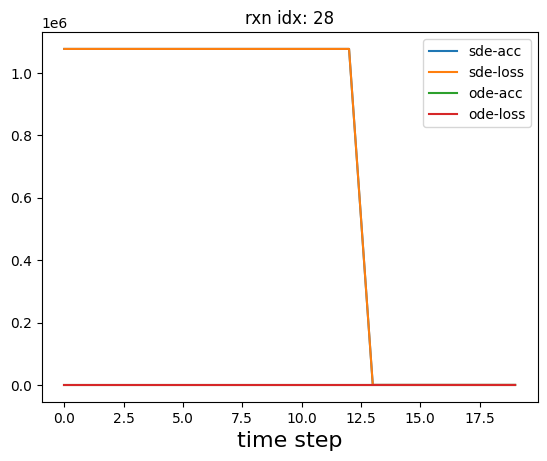

idx, gt_idx: 29, 43
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7782
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.009600613862494788
		debug: dx norm = 0.6480, dx_dot norm = 498.5601
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -38135767.83265264
		debug: dx norm = 100.3387, dx_dot norm = 36784.5176
			debug: dim = 9, num_zeros = 27
		debug: <x_ddot, x_dot> = -86840466652.74887
		debug: dx norm = 7267.1444, dx_dot norm = 17282349.0350
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
	debug: proj_q_dot norm = 1.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug

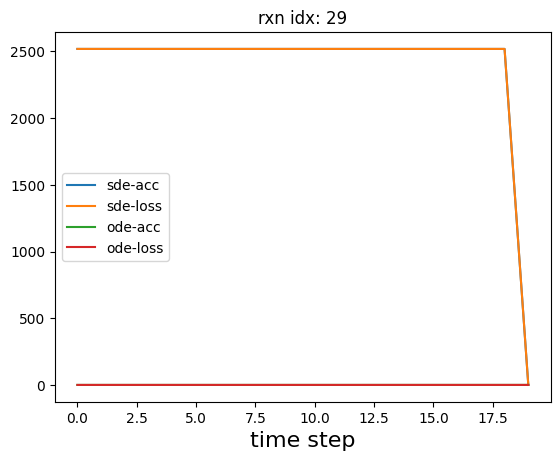

idx, gt_idx: 30, 44
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7829
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.897685860464228e-06
		debug: dx norm = 0.0088, dx_dot norm = 0.0010
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.46612518626957e-06
		debug: dx norm = 0.0087, dx_dot norm = 0.0011
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.987048635504099e-06
		debug: dx norm = 0.0086, dx_dot norm = 0.0012
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.480496213802145e-06
		debug: dx norm = 0.0084, dx_dot norm = 0.0013
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.965090508132465e-06
		debug: dx norm = 0.0082, dx_dot norm = 0.0013
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.6010
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.593538902171119e-05
		debug: dx norm = 0.0173, dx_dot norm = 0.0023
			debug: dim = 30, num_zeros

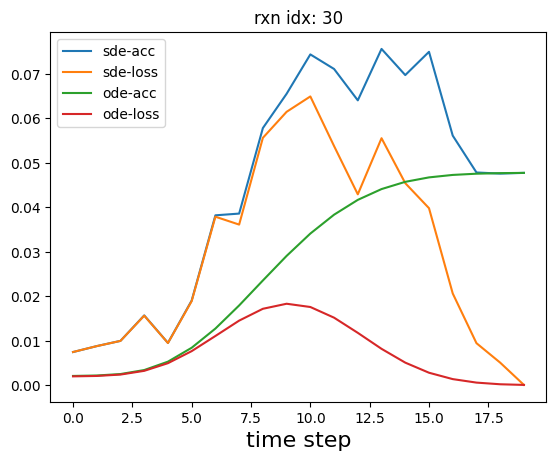

idx, gt_idx: 31, 45
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7668
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.597124862858597e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0010
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.319593467693843e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0009
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.048538687605205e-06
		debug: dx norm = 0.0145, dx_dot norm = 0.0010
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.790494729043778e-06
		debug: dx norm = 0.0144, dx_dot norm = 0.0010
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.549802693268055e-06
		debug: dx norm = 0.0143, dx_dot norm = 0.0011
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.6665
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.5338314293567715e-05
		debug: dx norm = 0.0109, dx_dot norm = 0.0005
			debug: dim = 30, num_zer

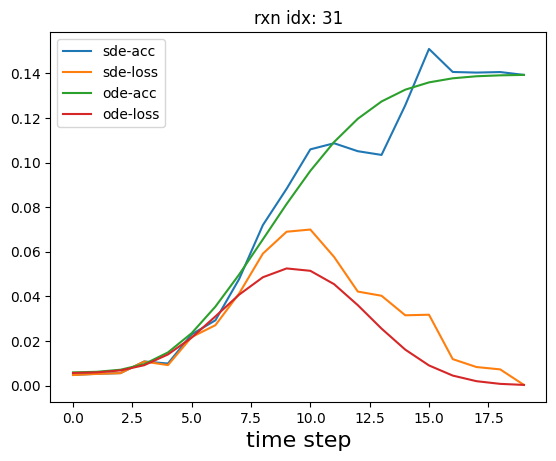

idx, gt_idx: 32, 46
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7191
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.6126694691598152e-05
		debug: dx norm = 0.3122, dx_dot norm = 6.3258
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 83.75522598814209
		debug: dx norm = 1.0689, dx_dot norm = 61.0224
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -4040.1575160617535
		debug: dx norm = 13.0791, dx_dot norm = 930.6844
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 61111067.10341051
		debug: dx norm = 173.1162, dx_dot norm = 163833.2060
			debug: dim = 3, num_zeros = 33
		debug: <x_ddot, x_dot> = 18274.921562929034
		debug: dx norm = 32762.8208, dx_dot norm = 6643364.7802
			debug: dim = 0, num_zeros = 36
	debug: proj_q_dot norm = 1.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		de

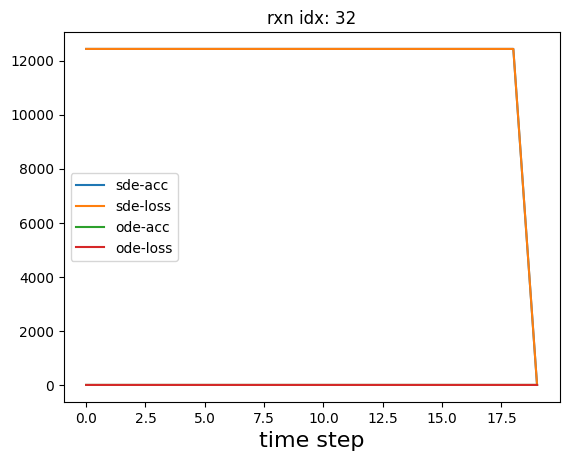

idx, gt_idx: 33, 47
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.7286
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.6216302987947185e-05
		debug: dx norm = 0.0710, dx_dot norm = 0.1141
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.0003680139778841894
		debug: dx norm = 0.0549, dx_dot norm = 0.0364
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.00031809978480234
		debug: dx norm = 0.0484, dx_dot norm = 0.0280
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.0002782422032275837
		debug: dx norm = 0.0433, dx_dot norm = 0.0217
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.0002447255998836401
		debug: dx norm = 0.0394, dx_dot norm = 0.0169
			debug: dim = 30, num_zeros = 6
	debug: proj_q_dot norm = 0.5603
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.00014196082248236477
		debug: dx norm = 0.0717, dx_dot norm = 0.0363
			debug: dim = 30, num_zeros

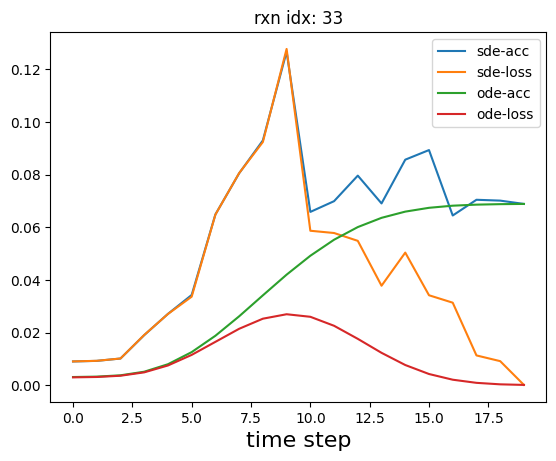

idx, gt_idx: 34, 49
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 28, num_zeros = 8
	debug: proj_q_dot norm = 0.7773
			debug: dim = 28, num_zeros = 8
		debug: <x_ddot, x_dot> = -0.1941348315477181
		debug: dx norm = 2.4368, dx_dot norm = 455.0106
			debug: dim = 30, num_zeros = 6
		debug: <x_ddot, x_dot> = -6627779.181414952
		debug: dx norm = 88.5808, dx_dot norm = 55977.2064
			debug: dim = 6, num_zeros = 30
		debug: <x_ddot, x_dot> = 366392775080.07825
		debug: dx norm = 11127.0261, dx_dot norm = 14404966.8766
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
	debug: proj_q_dot norm = 1.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug: dx norm = 0.0000, dx_dot norm = 0.0000
			debug: dim = 0, num_zeros = 36
		debug: <x_ddot, x_dot> = 0.0
		debug:

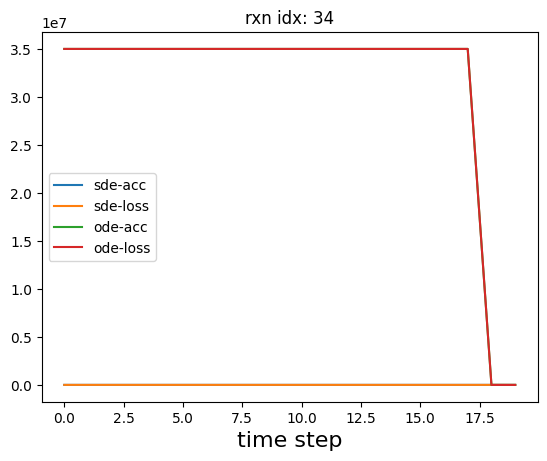

idx, gt_idx: 35, 52
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7817
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.069097304463826e-06
		debug: dx norm = 0.0127, dx_dot norm = 0.0007
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.091633390782794e-06
		debug: dx norm = 0.0127, dx_dot norm = 0.0006
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.1064615900288784e-06
		debug: dx norm = 0.0126, dx_dot norm = 0.0006
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.1123039937835295e-06
		debug: dx norm = 0.0126, dx_dot norm = 0.0006
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.1082793940192895e-06
		debug: dx norm = 0.0126, dx_dot norm = 0.0006
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7688
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -3.9124643749278886e-05
		debug: dx norm = 0.0186, dx_dot norm = 0.0022
			debug: dim = 33, num_

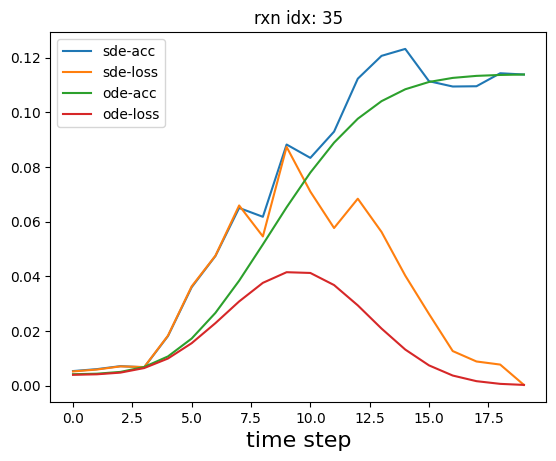

idx, gt_idx: 36, 53
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7722
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.249587716181548e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0005
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.200508513519063e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0005
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.152010344318747e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0005
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.103825440481153e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0005
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.056693059563199e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0005
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7559
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.358865711509163e-05
		debug: dx norm = 0.0262, dx_dot norm = 0.0019
			debug: dim = 33, num_zero

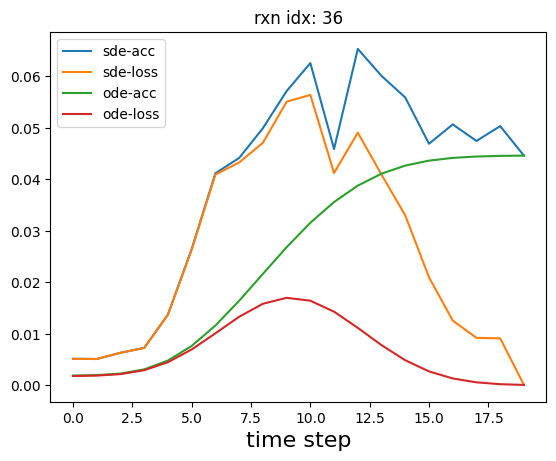

idx, gt_idx: 37, 54
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7416
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.175009269048338e-06
		debug: dx norm = 0.0170, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.215483805574638e-06
		debug: dx norm = 0.0169, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.237609859692786e-06
		debug: dx norm = 0.0169, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.242175489423867e-06
		debug: dx norm = 0.0168, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 7.231507253306741e-06
		debug: dx norm = 0.0167, dx_dot norm = 0.0008
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7577
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.3413779517505226e-05
		debug: dx norm = 0.0140, dx_dot norm = 0.0012
			debug: dim = 33, num_zer

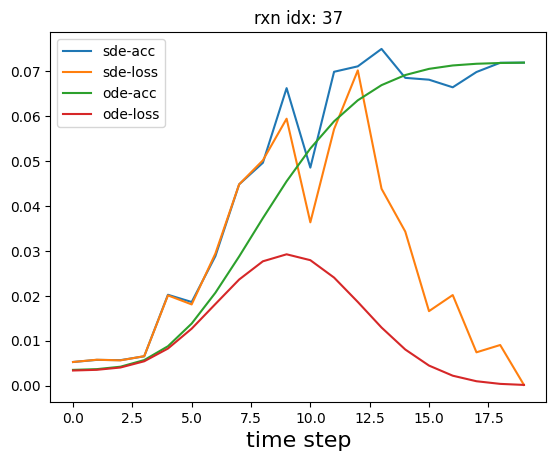

idx, gt_idx: 38, 55
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7212
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.6207026931224685e-05
		debug: dx norm = 0.0193, dx_dot norm = 0.0012
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.6015945277992693e-05
		debug: dx norm = 0.0193, dx_dot norm = 0.0012
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.5802243543798236e-05
		debug: dx norm = 0.0192, dx_dot norm = 0.0013
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.556649096033193e-05
		debug: dx norm = 0.0191, dx_dot norm = 0.0013
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.5311296519026322e-05
		debug: dx norm = 0.0190, dx_dot norm = 0.0013
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7034
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.136064577802576e-05
		debug: dx norm = 0.0257, dx_dot norm = 0.0074
			debug: dim = 33, num_

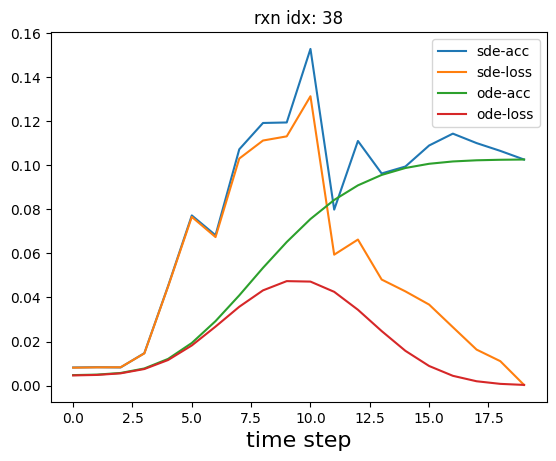

idx, gt_idx: 39, 57
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6693
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.57902489546561e-06
		debug: dx norm = 0.0200, dx_dot norm = 0.0019
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.077831444229475e-06
		debug: dx norm = 0.0197, dx_dot norm = 0.0018
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -3.6196885464723365e-06
		debug: dx norm = 0.0195, dx_dot norm = 0.0017
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -3.200021751462788e-06
		debug: dx norm = 0.0193, dx_dot norm = 0.0017
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.8169667121654567e-06
		debug: dx norm = 0.0191, dx_dot norm = 0.0016
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6793
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -7.687174185044634e-06
		debug: dx norm = 0.0171, dx_dot norm = 0.0020
			debug: dim = 27, nu

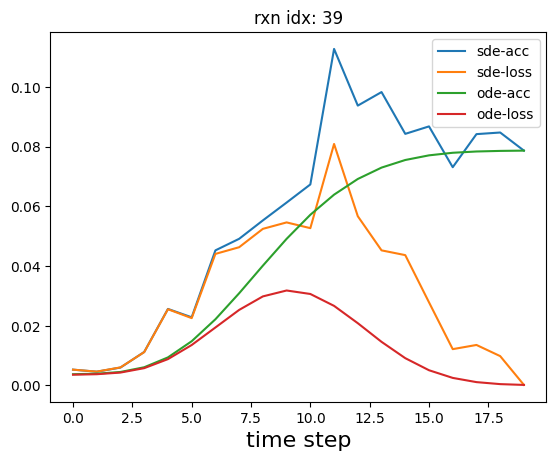

idx, gt_idx: 40, 58
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6579
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.750423064209671e-06
		debug: dx norm = 0.0114, dx_dot norm = 0.0028
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.016954940183319e-06
		debug: dx norm = 0.0109, dx_dot norm = 0.0024
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -3.4417067212986593e-06
		debug: dx norm = 0.0105, dx_dot norm = 0.0022
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.980776946083848e-06
		debug: dx norm = 0.0102, dx_dot norm = 0.0019
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -2.6048151401859342e-06
		debug: dx norm = 0.0099, dx_dot norm = 0.0018
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6918
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.00031931409996794106
		debug: dx norm = 0.0492, dx_dot norm = 0.0451
			debug: dim = 27, n

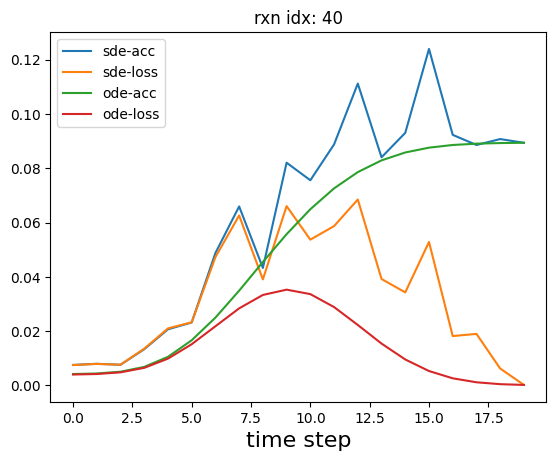

idx, gt_idx: 41, 60
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6952
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.128585637515619e-07
		debug: dx norm = 0.0060, dx_dot norm = 0.0002
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.0799869993680044e-07
		debug: dx norm = 0.0060, dx_dot norm = 0.0002
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.032156534801751e-07
		debug: dx norm = 0.0060, dx_dot norm = 0.0002
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.9850902928626555e-07
		debug: dx norm = 0.0060, dx_dot norm = 0.0002
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.9388758592576447e-07
		debug: dx norm = 0.0059, dx_dot norm = 0.0002
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6485
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 6.384154724227343e-06
		debug: dx norm = 0.0198, dx_dot norm = 0.0034
			debug: dim = 27, num_ze

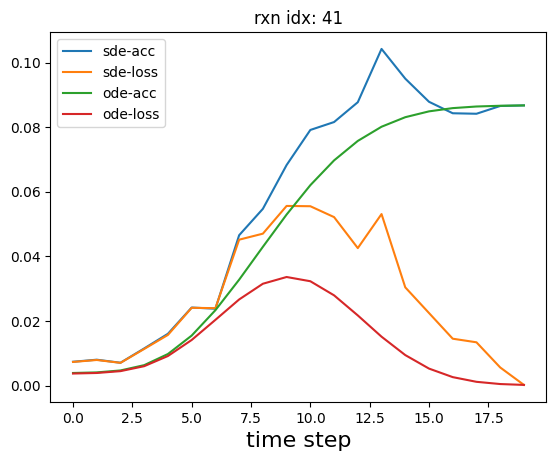

idx, gt_idx: 42, 61
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6029
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.0001461516230853633
		debug: dx norm = 0.0591, dx_dot norm = 0.0198
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.00012155559698233313
		debug: dx norm = 0.0582, dx_dot norm = 0.2317
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.00021369656599041999
		debug: dx norm = 0.0172, dx_dot norm = 0.0179
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.0001247022060395108
		debug: dx norm = 0.0152, dx_dot norm = 0.0113
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = 8.009519116252914e-05
		debug: dx norm = 0.0143, dx_dot norm = 0.0080
			debug: dim = 27, num_zeros = 6
	debug: proj_q_dot norm = 0.6544
			debug: dim = 27, num_zeros = 6
		debug: <x_ddot, x_dot> = -0.0001283456144062957
		debug: dx norm = 0.0269, dx_dot norm = 0.0139
			debug: dim = 27, num_

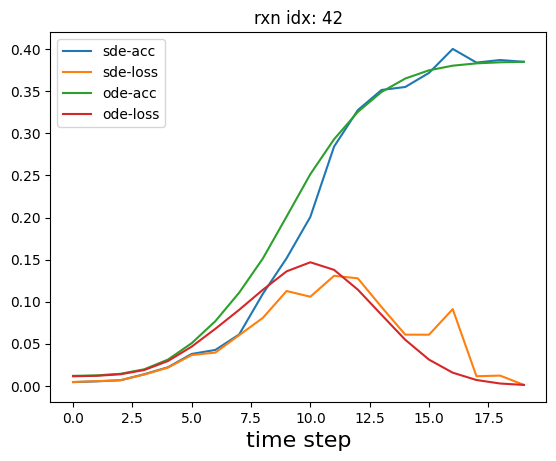

idx, gt_idx: 43, 62
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7666
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.5159430566353225e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0003
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.502538847079237e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0003
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.489851571486215e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0003
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.477860274192539e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0003
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 5.466653695031956e-06
		debug: dx norm = 0.0115, dx_dot norm = 0.0003
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7066
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -7.701798424825676e-06
		debug: dx norm = 0.0169, dx_dot norm = 0.0007
			debug: dim = 39, num_zer

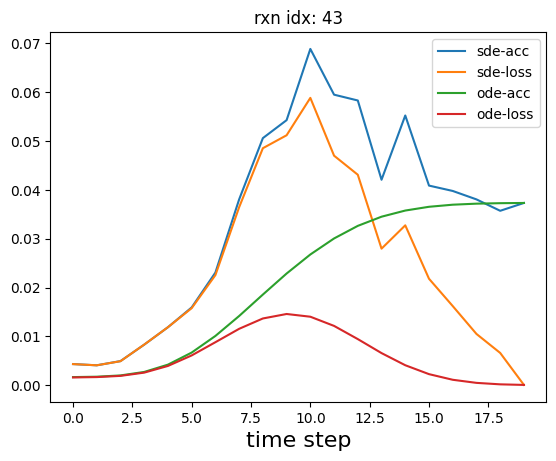

idx, gt_idx: 44, 63
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7582
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -6.558743692501499e-05
		debug: dx norm = 0.0191, dx_dot norm = 0.0031
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -6.97104756458894e-05
		debug: dx norm = 0.0194, dx_dot norm = 0.0025
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -7.074762581521969e-05
		debug: dx norm = 0.0194, dx_dot norm = 0.0026
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -6.827698529530927e-05
		debug: dx norm = 0.0191, dx_dot norm = 0.0034
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -6.300598099938014e-05
		debug: dx norm = 0.0185, dx_dot norm = 0.0041
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7275
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.350013317692334e-05
		debug: dx norm = 0.0253, dx_dot norm = 0.0029
			debug: dim = 39, num_z

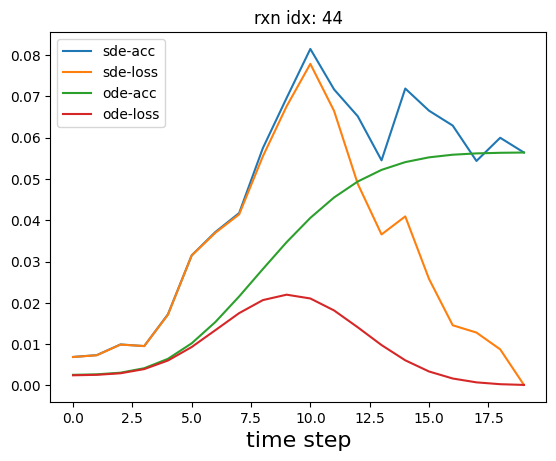

idx, gt_idx: 45, 65
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7603
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.693039585533093e-06
		debug: dx norm = 0.0149, dx_dot norm = 0.0010
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.626467234765872e-06
		debug: dx norm = 0.0149, dx_dot norm = 0.0011
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.488613918301487e-06
		debug: dx norm = 0.0148, dx_dot norm = 0.0011
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.285100158953583e-06
		debug: dx norm = 0.0148, dx_dot norm = 0.0011
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -8.02407573844986e-06
		debug: dx norm = 0.0147, dx_dot norm = 0.0011
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7405
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.8412841288754382e-05
		debug: dx norm = 0.0241, dx_dot norm = 0.0030
			debug: dim = 39, num_

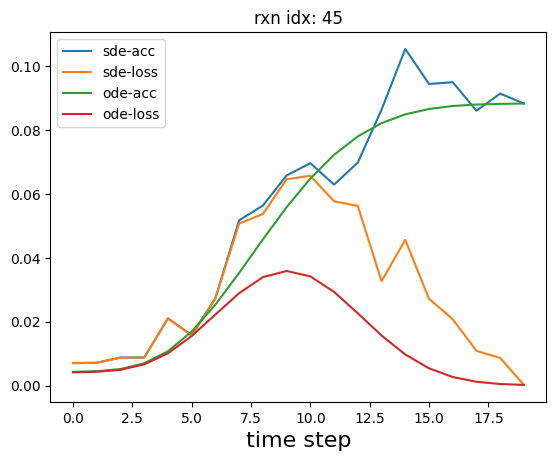

idx, gt_idx: 46, 67
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7872
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.61903731470115e-06
		debug: dx norm = 0.0129, dx_dot norm = 0.0009
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.590613485217024e-06
		debug: dx norm = 0.0129, dx_dot norm = 0.0010
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.4367455047651055e-06
		debug: dx norm = 0.0129, dx_dot norm = 0.0011
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -4.171320131723325e-06
		debug: dx norm = 0.0128, dx_dot norm = 0.0012
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -3.817544807614379e-06
		debug: dx norm = 0.0128, dx_dot norm = 0.0013
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7304
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 0.00018789744286209863
		debug: dx norm = 0.0364, dx_dot norm = 0.0210
			debug: dim = 39, num

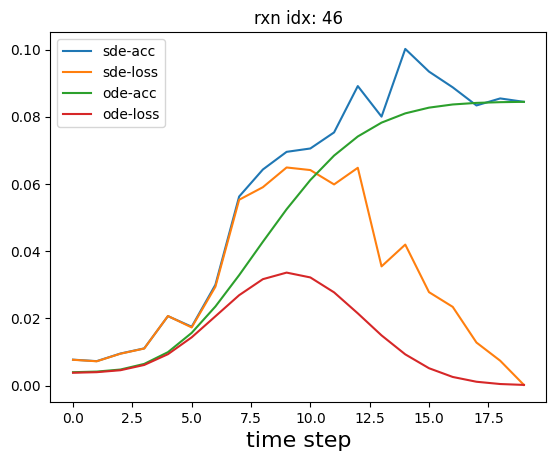

idx, gt_idx: 47, 70
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7714
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 9.931934437442947e-06
		debug: dx norm = 0.0156, dx_dot norm = 0.0006
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 9.96325304739699e-06
		debug: dx norm = 0.0156, dx_dot norm = 0.0006
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 9.994633769236308e-06
		debug: dx norm = 0.0156, dx_dot norm = 0.0006
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.0026168929824382e-05
		debug: dx norm = 0.0156, dx_dot norm = 0.0006
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.0058130715971432e-05
		debug: dx norm = 0.0157, dx_dot norm = 0.0006
			debug: dim = 39, num_zeros = 6
	debug: proj_q_dot norm = 0.7546
			debug: dim = 39, num_zeros = 6
		debug: <x_ddot, x_dot> = -6.6557373658811866e-06
		debug: dx norm = 0.0299, dx_dot norm = 0.0081
			debug: dim = 39, num_ze

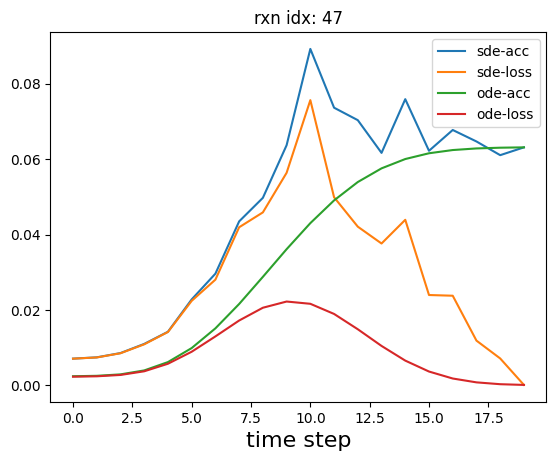

idx, gt_idx: 48, 71
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.8326
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.275146133710421e-06
		debug: dx norm = 0.0100, dx_dot norm = 0.0020
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 2.121010406715042e-06
		debug: dx norm = 0.0102, dx_dot norm = 0.0022
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.9254246347696163e-06
		debug: dx norm = 0.0104, dx_dot norm = 0.0026
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.6680373457843783e-06
		debug: dx norm = 0.0106, dx_dot norm = 0.0031
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 1.3132571352390412e-06
		debug: dx norm = 0.0110, dx_dot norm = 0.0038
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.6640
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -1.0167075167464737e-05
		debug: dx norm = 0.0189, dx_dot norm = 0.0037
			debug: dim = 33, num_

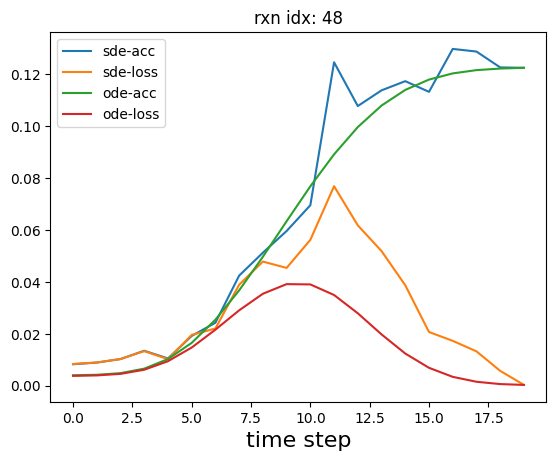

idx, gt_idx: 49, 72
Debug: alpha, beta = 1.7, 0.01
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.7879
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.88263453450245e-06
		debug: dx norm = 0.0085, dx_dot norm = 0.0004
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.846326413273627e-06
		debug: dx norm = 0.0085, dx_dot norm = 0.0004
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.8092802785362616e-06
		debug: dx norm = 0.0085, dx_dot norm = 0.0004
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.771544908668685e-06
		debug: dx norm = 0.0085, dx_dot norm = 0.0004
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = 3.7331657368772435e-06
		debug: dx norm = 0.0084, dx_dot norm = 0.0004
			debug: dim = 33, num_zeros = 6
	debug: proj_q_dot norm = 0.6808
			debug: dim = 33, num_zeros = 6
		debug: <x_ddot, x_dot> = -6.623785586233252e-06
		debug: dx norm = 0.0137, dx_dot norm = 0.0005
			debug: dim = 33, num_zer

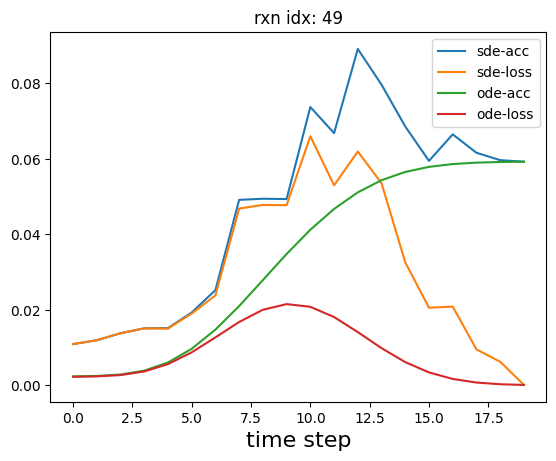

Done!


In [178]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

# num_time_steps = [100, 250, 500, 1000][1]
num_time_steps = 20
inner_iteration = 5
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][1]
print(f"q_type = {q_type}")

# for idx in [9, 10, 34]:
# for idx in [34]:
for idx in range(50):
# for idx in [12]:
    err_at_zero_t = []
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test,
                                               inner_iteration=inner_iteration, outer_iteration=250)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "sde-acc")
    plot_traj(v1[::-1], "sde-loss")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test, 
                                               inner_iteration=inner_iteration, outer_iteration=250)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")

    print("err_at_zero_t = ", err_at_zero_t)
    
    # plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
print("Done!")

q_type = morse
idx, gt_idx: 34, 49
Debug: alpha, beta = 1.7, 0.01
debug ] time : 0.878
debug ] diff.norm() : 0.00028006231196792196
debug ] dd.norm() : 8.468964629880968e-05
			debug: dim = 25, num_zeros = 11
	debug: proj_q_dot norm = 0.0987
			debug: dim = 25, num_zeros = 11
		debug: <x_ddot, x_dot> = 1.520392992232392e-13
		debug: dx norm = 0.0001, dx_dot norm = 0.0000
			debug: dim = 25, num_zeros = 11
		debug: <x_ddot, x_dot> = 1.52036501176846e-13
		debug: dx norm = 0.0001, dx_dot norm = 0.0000
			debug: dim = 25, num_zeros = 11
		debug: <x_ddot, x_dot> = 1.5203370206883258e-13
		debug: dx norm = 0.0001, dx_dot norm = 0.0000
			debug: dim = 25, num_zeros = 11
		debug: <x_ddot, x_dot> = 1.5203091248752573e-13
		debug: dx norm = 0.0001, dx_dot norm = 0.0000
			debug: dim = 25, num_zeros = 11
		debug: <x_ddot, x_dot> = 1.5202811124883634e-13
		debug: dx norm = 0.0001, dx_dot norm = 0.0000
debug ] dx.norm() : 0.0002662631341861176
debug ] time : 0.855
debug ] diff.norm() : 0.000419588

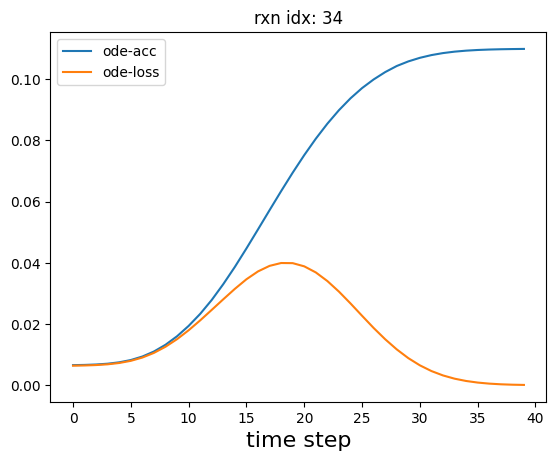

Done!


In [190]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""

# num_time_steps = [100, 250, 500, 1000][1]
num_time_steps = 40
inner_iteration = 5
h_coeff = 0.0
verbose = [True, False][1]
q_type = ["DM", "morse"][1]
sampling_test = [0, 1][1]
print(f"q_type = {q_type}")

# for idx in [34, 42,60,78,238,304,344,458,718,746,774,884,913]:
# for idx in [238]:
for idx in [34]:
    err_at_zero_t = []
    # reverse_traj, v1, v2, v3, v4 = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, 
    #                                            verbose=verbose, q_type=q_type, sampling_test=sampling_test,
    #                                            inner_iteration=inner_iteration, outer_iteration=500)
    # err_at_zero_t.append(v2[-1].item())
    # plot_traj(v2[::-1], "sde-acc")
    # plot_traj(v1[::-1], "sde-loss")
    reverse_traj, v1, v2, v3, v4 = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, 
                                               verbose=verbose, q_type=q_type, sampling_test=sampling_test, 
                                               inner_iteration=inner_iteration, outer_iteration=500)
    err_at_zero_t.append(v2[-1].item())
    plot_traj(v2[::-1], "ode-acc")
    plot_traj(v1[::-1], "ode-loss")

    print("err_at_zero_t = ", err_at_zero_t)
    
    # plt.ylim(0, v2[num_time_steps // 2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
print("Done!")

# ODE sampling issue!

주로 Planar한 구조에서 시작하는 경우 ODE sampling이 터지는 것을 여러번 확인 할 수 있었다.

SVD를 이용한 pseudo-inverse 과정에서 singular-value threshold를 조절하여 (1e-4 > 1e-3) ODE가 터지는걸 막을 수 있었다.

그리고, time-step을 20 > 40 으로 바꾸니까 ODE 터지는 경우도 많이 줄었다.

하지만, t=0 에서 살짝 뜨는 경향은 있었고, 이게 1) SVD에 의한 영향 2) time-step 에 의한 영향 3) sampler 의 영향인지 알 필요가 있다.


In [363]:
## wrapper class to save atoms object

class Wrapper:
    def __init__(self, atoms_0, atoms_T, q_type="DM", alpha=1.7, beta=0.01, gamma=0.01, using_jacobian=True, svd_tol=1e-4):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type
        self.svd_tol = svd_tol
        self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0
        self.using_jacobian = using_jacobian
        return

    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def calc_inverse_jacobian(self, pos, q_type):
        edge_index, edg_length = self.pos_to_dist(pos)
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)
        inverse_jacobain = []

        for ij, d, de in zip(edge_index.T, distance, distance_e):
            jacob = torch.zeros(size=pos.size())
            i, j = ij
            pos_i, pos_j = pos[i], pos[j]
            d_pos = pos_i - pos_j
            if q_type == "DM":
                dr_dd = d / d_pos
                jacob[i] = dr_dd
                jacob[j] = - dr_dd
                
            elif q_type == "morse":
                dr_dq = d ** 3 * de  / - (self.alpha * np.exp(- self.alpha * (d / de - 1)) + self.beta * de ** 2) / d_pos
                jacob[i] = dr_dq
                jacob[j] = - dr_dq
            inverse_jacobain.append(jacob.flatten())
        return torch.stack(inverse_jacobain, dim=0)
                
        
    def calc_jacobian(self, pos, q_type):
        # pos = Tensor, (N, 3)
        edge_index, edge_length = self.pos_to_dist(pos)
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        jacobian = []
        for i_idx in range(len(pos)):
            j_idx = list(range(len(pos)))
            j_idx.remove(i_idx)
            j_idx = torch.LongTensor(j_idx)

            j_mask = torch.any(edge_index == i_idx, axis=0)
            dd_dx = torch.zeros(size=(len(edge_length), 3))
            dq_dx = torch.zeros(size=(len(edge_length), 3))
            pos_i = pos[i_idx].reshape(1, -1)
            pos_j = pos[j_idx]

            dist = distance[j_mask].reshape(-1, 1)
            dd_dx[j_mask] += (pos_i - pos_j) / dist

            if q_type == "DM":
                jacobian.append(dd_dx.T)

            elif q_type == "morse":
                dq_dd = - (self.alpha / distance_e[j_mask]) * np.exp(-self.alpha * (distance[j_mask] - distance_e[j_mask]) / distance_e[j_mask])
                dq_dd -= self.beta * distance_e[j_mask] / (distance[j_mask] ** 2)
                dq_dx[j_mask] += dd_dx[j_mask] * dq_dd.reshape(-1, 1)
                jacobian.append(dq_dx.T)
                
            elif q_type == "morese+DM":
                raise NotImplementedError

        return torch.cat(jacobian, dim=0)
    
    def calc_distance_hessian(self, pos, edge_index, distance):
        N = len(pos)
        K = len(edge_index)
        hessian = torch.zeros(size=(K, 3 * N, 3 * N))
        for k, (ij, d_ij) in enumerate(zip(edge_index, distance)):
            i, j = ij
            pos_i, pos_j = pos[i], pos[j]

            # calculate hessian related to i, j atoms
            d_pos = pos_i - pos_j
            hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ij /= d_ij ** 3
            hess_ij -= torch.eye(3) / d_ij
            
            # calculate hessian related to i, i atoms
            hess_ii = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ii /= - d_ij ** 3
            hess_ii += torch.eye(3) / d_ij
            
            # hess_ii = hess_jj
            hess_jj = hess_ii

            hessian[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
            hessian[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_jj
            hessian[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
            hessian[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
            
        return hessian
    
    def calc_hessian(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
            
        edge_index, edge_length = self.pos_to_dist(pos)
        edge_index = edge_index.T
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        hessian = self.calc_distance_hessian(pos, edge_index, distance)
        
        if q_type == "DM":
            return hessian
        
        elif q_type == "morse":
            dq_dd = - self.alpha / distance_e * np.exp(-self.alpha * (distance - distance_e) / distance_e)
            dq_dd -= self.beta * distance_e / (distance ** 2)
            hessian_q = hessian * dq_dd.reshape(-1, 1, 1)
            
            for k, (ij, d_ij, de_ij) in enumerate(zip(edge_index, distance, distance_e)):
                i, j = ij
                pos_i, pos_j = pos[i], pos[j]
                # calculate hessian related to i, j atoms
                d_pos = pos_i - pos_j
                hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
                hess_ij /= - d_ij ** 2
                coeff = self.alpha ** 2 / de_ij ** 2 * np.exp(-self.alpha * (d_ij - de_ij) / de_ij)  + 2 * self.beta * de_ij / (d_ij ** 3)
                hess_ij *= coeff

                # calculate hessian related to i, i atoms
                hess_ii = - hess_ij
                
                hessian_q[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
                hessian_q[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_ii
                hessian_q[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
                hessian_q[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
                
            return hessian_q
        
        elif q_type == "morese+DM":
            raise NotImplementedError
        return 
             
    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.using_jacobian:
            jacobian = self.calc_jacobian(pos, q_type=self.q_type)
            
            score_pos = jacobian @ score_d.reshape(-1, 1)
            return score_pos.reshape(-1, 3)
            
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "morse+DM":
            edge_length = torch.Tensor(pdist(pos))
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr += self.gamma / edge_length
            dd_dr = dd_dr.reshape(-1, 1)
            score_d *= self.scaler_factor
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
        if q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            # print(wij, type(wij))
            # length = torch.Tensor(wij)
            length = wij
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                                  using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
            dx = - 1.0 * reverse_score_ * dt + dw
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index, d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                # every displacement is first calculated on the q-space, and then transformed to the Cartesian space
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw

                dx = self.eq_transform(dd, x_t, index, d_t)
            
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dw = torch.sqrt(beta_t * dt) * torch.randn_like(diff)
                dd = - 1.0 * reverse_score_ * dt + dw   
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True,
                            using_jacobian=True, sampling_test=1, inner_iteration=5):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            diff, coeff, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            reverse_score_ = diff * coeff
            dx = - 0.5 * reverse_score_ * dt
            print(f"Debug ({t:0.3f}): \n\t1) diff norm and dx norm {diff.norm():0.4f}, {dx.norm():0.6f}")
        else:
            diff, coeff, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            index ,d_t = self.pos_to_dist(x_t)

            if sampling_test == 0:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                dx = self.eq_transform(dd, x_t, index, d_t)                
                # Want to check why eq-transform does not work well
                diff_d = diff
                diff_x = self.eq_transform(diff_d, x_t, index, d_t)
                print(f"Debug ({t:0.3f}): \n\t1) diff-d norm and diff-x norm {diff_d.norm():0.4f}, {diff_x.norm():0.4f} \n\t2) dd-norm and dx-norm {dd.norm():0.6f}, {dx.norm():0.6f}")
                print(f"\t3) dx-norm/dd-norm {dx.norm()/dd.norm():0.6f}")
                
            elif sampling_test == 1:
                reverse_score_ = diff * coeff
                dd = - 0.5 * reverse_score_ * dt
                print(f"debug ] time : {t:0.3f}")
                print(f"debug ] diff.norm() : {diff.norm()}")
                print(f"debug ] dd.norm() : {dd.norm()}")
                x_tm1 = self.exponential_ode_solver(x_t, -dd, q_type=self.q_type, num_iter=inner_iteration, check_dot_every=3)
                dx = - x_tm1 + x_t
                print(f"debug ] dx.norm() : {dx.norm()}")
                
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_score(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

        # calc difference
        diff = mu_hat - x_t

        # calc_score    
        coeff =  1 / (sigma_t_hat_square) * beta_t
        score = diff * coeff
        
        # for debug
        if self.q_type == "DM":
        # if self.q_type in ["DM", "morse"]: # debugging # calculate err corresponding the metric
            _, d_T = self.pos_to_dist(x_T)
            _, d_t = self.pos_to_dist(x_t)
            _, d_0 = self.pos_to_dist(x_0)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
            v1 = (d_mu_hat - d_t).abs().mean()
            # v2 = (d_mu_hat - d_T).abs().mean()
            v2 = (d_0 - d_t).abs().mean()
            v3 = (mu_hat - x_t.numpy()).abs().mean()
            v4 = (mu_hat - x_T.numpy()).abs().mean()
        # elif self.q_type == "morse":
        elif self.q_type in ["morse", "morse+DM", "Cartesian"]:
            version = "DMAE"
            # version = "Morse-RMSD"
            if version == "DMAE":
                d_T = torch.Tensor(pdist(x_T))
                d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
                d_t = torch.Tensor(pdist(x_t))
                d_0 = torch.Tensor(pdist(x_0))
                v1 = (d_mu_hat - d_t).abs().mean()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).abs().mean()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
            else:
                _, d_T = self.pos_to_dist(x_T)
                _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
                _, d_t = self.pos_to_dist(x_t)
                _, d_0 = self.pos_to_dist(x_0)
                v1 = (d_mu_hat - d_t).norm()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).norm()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
        else:
            raise NotImplementedError
        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return diff, coeff, v1, v2, v3, v4

    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        
        # calc difference
        index, d_t = self.pos_to_dist(x_t)
        diff_d = d_mu_hat - d_t
        diff = diff_d
        coeff =  1 / (sigma_t_hat_square) * beta_t

        # for debugging
        d_T = torch.Tensor(pdist(x_T))
        d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
        d_t = torch.Tensor(pdist(x_t))
        d_0 = torch.Tensor(pdist(x_0))
        v_loss_mae = (d_mu_hat - d_t).abs().mean()  # DMAE
        v_acc_mae = (d_0 - d_t).abs().mean()  # DMAE

        original_q_type = copy.deepcopy(self.q_type)
        self.q_type = "morse"
        _, d_T = self.pos_to_dist(x_T)
        _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
        _, d_t = self.pos_to_dist(x_t)
        _, d_0 = self.pos_to_dist(x_0)
        v_loss_norm = (d_mu_hat - d_t).norm()  # q-norm
        v_acc_norm = (d_0 - d_t).norm()  # q-norm
        self.q_type = original_q_type
        

        if verbose:
            print(f"{t:0.3f}\t{v_loss_mae:0.4f}\t\t{v_acc_mae:0.4f}\t\t{v_loss_norm:0.4f}\t\t{v_acc_norm:0.4f}\t")
        return diff, coeff, v_loss_mae, v_acc_mae, v_loss_norm, v_acc_norm
    
    def exponential_ode_solver(self, x0, q_dot0, q_type="morse", num_iter=100, check_dot_every=10, thresh=1e-2, max_dt=1e-1, verbose=False):
        
        def one_step(x, x_dot, q_type=q_type, dt=1e-2, wrapper=self, refine_xdot=False, verbose=False):
            hess = wrapper.calc_hessian(x.reshape(-1, 3), q_type=q_type)
            jacob = wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T
            
            # J, J_inv = wrapper.refine_jacobian(jacob)
            J = jacob
            J_inv = torch.linalg.pinv(J, rtol=1e-4, atol=1e-2)

            JG = J_inv.T
            if refine_xdot:
                x_dot = J_inv @ J @ x_dot
                if verbose:
                    print(f"\t\t\tdebug: x_dot norm = {x_dot.norm():0.6f}")
            christoffel = torch.einsum("mij, mk->kij", hess, JG)
            x_ddot = - torch.einsum("j,kij,i->k", x_dot, christoffel, x_dot)
            
            # x_ddot and x_dot should be perpendicular 
            q_ddot = J @ x_ddot
            q_dot = J @ x_dot
            
            new_x = x + x_dot * dt
            new_x_dot = x_dot + x_ddot * dt
            
            # dotproduct
            if verbose:
                print(f"\t\tdebug: <x_ddot, x_dot> = {(q_ddot * q_dot).sum()}")
                print(f"\t\tdebug: <x_ddot, x_dot> = {((jacob.T @ jacob) @ x_dot.reshape(-1, 1) * x_ddot).sum()}")
                print(f"\t\tdebug: x_dot size = {x_dot.norm():0.8f}, x_ddot size = {x_ddot.norm():0.8f}")
                print(f"\t\tdebug: dx norm = {(new_x - x).norm():0.8f}, dx_dot norm = {(new_x_dot - x_dot).norm():0.8f}")
            return new_x, new_x_dot

        
        jacob = self.calc_jacobian(x0, q_type=q_type).T
        # J, J_inv = self.refine_jacobian(jacob)
        J = jacob
        J_inv = torch.linalg.pinv(J, rtol=1e-4, atol=self.svd_tol)

        # debugging
        proj_q_dot = J @ J_inv @ q_dot0
        if verbose >= 1:
            print(f"\tdebug: proj_q_dot norm = {proj_q_dot.norm():0.4f}")
            print(f"\tdebug: proj_q_dot norm-ratio = {(proj_q_dot - q_dot0).norm()/ q_dot0.norm():0.4f}")
        
        # initialization
        x_dot0 = J_inv @ q_dot0
        x = x0.flatten()
        x_dot = x_dot0

        total_time = x_dot.norm()
        x_dot = x_dot / x_dot.norm()
        
        q = self.pos_to_dist(x.reshape(-1, 3))[1]
        # make time grid, 0 ~ total_time.
        # time spacing should be smaller than 1e-2
        # thresh = 5e-2
        # thresh = 1e-1
        # if total_time > num_iter * thresh:
        #     num_iter = int(total_time / thresh)
        
        # t = torch.linspace(0, total_time, num_iter + 1)[:-1]
        # # t = torch.linspace(0, 1, num_iter + 1)[:-1]
        # dt_ = t[1] - t[0]
        # dt = dt_
        # print(f"\tdebug: x_dot0.norm() = {x_dot0.norm()}")
        # print(f"\tdebug: x_dot0.norm() = {total_time.item():0.6f}")
        # solve the geodesic ODE iteratively
        # for i, t_i in enumerate(t):
        
        dt_ = min(total_time / num_iter, thresh)
        dt = dt_
        if verbose >= 1:
            print(f"initial dt = {dt_:0.6f}, total_expected_iter = {total_time / dt_:1.0f}")
            
        if verbose == 1:
            print("Progress-bar\n0%[--------------------]100%")
            print("0%[", end="")
        current_time = 0
        iter = 0
        cnt = 0
        total_dq = 0
        while total_time > current_time:
            # do_refine = i % check_dot_every == 0
            do_refine = False
            x_new, x_dot_new = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine, verbose=verbose >= 3)
            current_time += dt
            
            # calculate dq
            q_new = self.pos_to_dist(x_new.reshape(-1, 3))[1]
            dq = (q_new - q).norm()
            total_dq += dq
            q = q_new
            if verbose >= 2:
                if iter % 25 == 0:
                    print(f"\tdebug: time = ({(current_time / total_time) * 100:0.4f}%), iter = {iter}, dt = {dt:0.6f}, dq = {dq:0.6f}")
            iter += 1
            
            x = x_new
            x_dot = x_dot_new
            # dt = x_dot.norm() * dt_
            dt = min(max(dt_, 1 / x_dot.norm() * dt_), max_dt)
            if current_time / total_time > cnt / 10 and verbose == 1:
                print(f"--", end="")
                cnt += 1
            if total_time - current_time < dt:
                dt = total_time - current_time
        # for i, t_i in enumerate(t):
        #     print(f"\tdebug: time = {t_i:0.4f} ({i/len(t) * 100:0.2f}%)")
        #     # do_refine = i % check_dot_every == 0
        #     do_refine = False
        #     x, x_dot = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=self, refine_xdot=do_refine)
        if verbose == 1:
            print("]100%")
        return x.reshape(-1, 3), iter, total_dq
    
    
    def svd(self, jacob, verbose=False):
        U, S, Vh = torch.linalg.svd(jacob)
        num_zeros = (S < self.svd_tol).sum()
        dim = len(S) - num_zeros
        S = S[:dim]
        U = U[:, :dim]
        Vh = Vh[:dim, :]
        if verbose:
            print(f"\t\t\tdebug: dim = {dim}, num_zeros = {num_zeros}, singular values = {S[-1].item():0.6f} ~ {S[0].item():0.6f}")
        return U, S, Vh

    def refine_jacobian(self, jacob):
        # find non-zero singular values
        U, S, Vh = self.svd(jacob)
        J = U @ torch.diag(S) @ Vh
        J_inv = Vh.T @ torch.diag(1 / S) @ U.T
        return J, J_inv
        

# Numerical stability hadling

1. control $\alpha$, $\beta$

2. Solve ODE with varying $dt$ : (fixed $dt$ to fixed $dx$)

## Exp-4.1) Check how the condtion number and minimum singular value change according to the $\alpha$ and $\beta$

In [247]:
# experiment 4-1
# We want to check the effect of alpha and beta onto the singular values, especially the condition number of jacobian.

def check_condition_number(idx, alpha=1.4, beta=0.6):
    q_type = "morse"
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    # load wrapper
    gamma = 0.0

    # print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True, svd_tol=1e-10)

    x0 = torch.Tensor(x0.positions)
    xT = torch.Tensor(xT.positions)
    
    jacob = wrapper.calc_jacobian(xT, q_type=q_type)
    U, S, Vh = torch.linalg.svd(jacob)
    min_s_T = S[S > 1e-10][-1]
    max_s_T = S[S > 1e-10][0]
    
    jacob = wrapper.calc_jacobian(x0, q_type=q_type)
    U, S, Vh = torch.linalg.svd(jacob)
    min_s_0 = S[S > 1e-10][-1]
    max_s_0 = S[S > 1e-10][0]
    return min_s_T, min_s_0, max_s_T, max_s_0


In [294]:
# alpha beta tuple
ab = [(1.4, 0.6), (1.4, 0.7), (1.4, 0.8), (1.4, 0.9), (1.4, 1.0)]
ab += [(1.3, 0.6), (1.2, 0.6), (1.1, 0.6), (1.0, 0.6), (0.9, 0.6)]
fraction = 20
result_dict = {}
for alpha, beta in ab:
    S_0 = []
    S_T = []
    S_0_max = []
    S_T_max = []
    
    for idx in tqdm.tqdm(range(len(atoms_T) // fraction), total=len(atoms_T) // fraction):
        min_s_T, min_s_0, max_s_T, max_s_0 = check_condition_number(idx, alpha=alpha, beta=beta)    
        S_0.append(min_s_0.item())
        S_T.append(min_s_T.item())
        S_0_max.append(max_s_0.item())
        S_T_max.append(max_s_T.item())

    S_0 = np.array(S_0)
    S_T = np.array(S_T)
    S_0_max = np.array(S_0_max)
    S_T_max = np.array(S_T_max)
    data = [S_0, S_T, S_0_max, S_T_max]
    k = f"alpha={alpha}, beta={beta}"
    result_dict[k] = data
    

100%|██████████| 359/359 [00:06<00:00, 59.20it/s]


alpha=1.4, beta=0.6
	0.0795,	 0.0748
	6.9638%, 6.9638%
	0.0264, 0.0247
alpha=1.4, beta=0.7
	0.0857,	 0.0808
	6.4067%, 6.4067%
	0.0271, 0.0254
alpha=1.4, beta=0.8
	0.0920,	 0.0868
	5.2925%, 5.2925%
	0.0277, 0.0260
alpha=1.4, beta=0.9
	0.0982,	 0.0927
	5.0139%, 5.0139%
	0.0283, 0.0266
alpha=1.4, beta=1.0
	0.1045,	 0.0987
	5.0139%, 5.0139%
	0.0289, 0.0271
alpha=1.3, beta=0.6
	0.0840,	 0.0791
	6.6852%, 6.6852%
	0.0293, 0.0274
alpha=1.2, beta=0.6
	0.0889,	 0.0839
	6.4067%, 6.4067%
	0.0326, 0.0306
alpha=1.1, beta=0.6
	0.0943,	 0.0892
	6.1281%, 6.1281%
	0.0365, 0.0344
alpha=1.0, beta=0.6
	0.1002,	 0.0949
	5.5710%, 5.5710%
	0.0411, 0.0387
alpha=0.9, beta=0.6
	0.1066,	 0.1012
	5.2925%, 5.2925%
	0.0464, 0.0438


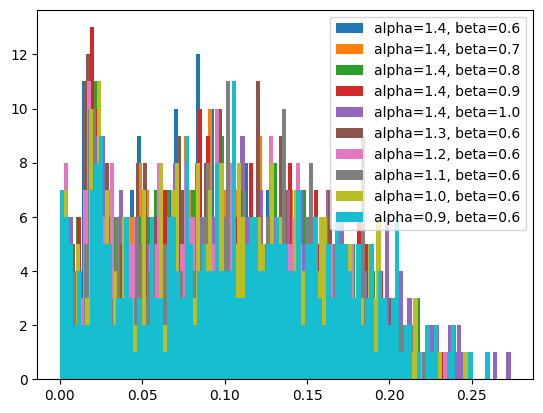

In [199]:
for k, v in result_dict.items():
    print(f"{k}\n\t{np.mean(v[0]):0.4f},\t {np.mean(v[1]):0.4f}")
    print(f"\t{(v[0] < 0.01).mean() * 100:0.4f}%, {(v[0] < 0.01).mean() * 100:0.4f}%")
    cn1, cn2 = v[0] / v[2], v[1] / v[3]
    print(f"\t{cn1.mean():0.4f}, {cn2.mean():0.4f}")
    _ = plt.hist(v[0], label=k, bins=100)
plt.legend()

## Exp-4.2) searching a criteria of $dx$.



In [369]:
def rmsd(x):
    return (x ** 2).sum(-1).mean().sqrt()

def solve_ode(idx, initial="random", sigma=1e-1, alpha=1.4, beta=0.6, check_singular_values=False, sv_cutoff=1e-2, thresh=5e-3, max_dt=5e-2, verbose=1, svd_tol=1e-2):
    # load molecules
    q_type = "morse"
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    # load wrapper
    gamma = 0.0

    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=True, svd_tol=1e-10)

    x0 = torch.Tensor(x0.positions)
    xT = torch.Tensor(xT.positions)

    jacob = wrapper.calc_jacobian(xT, q_type=q_type).T
    hess = wrapper.calc_hessian(xT, q_type=q_type)
    U, S, Vh = torch.linalg.svd(jacob)
    U_list = [U[:, i] for i in range(len(S)-6)]
    V_list = [Vh[i] for i in range(len(S)-6)]

    J_inv = torch.linalg.pinv(jacob, rtol=1e-4, atol=1e-4)

    if check_singular_values:
        print("index\t\t x_ddot\t\t x_dot\t\t s\t\t u\t\t v")
        for idx in range(len(S)-6):
            coeff = 1e-1
            v = V_list[idx] * coeff
            u = U_list[idx] * coeff

            x_dot = J_inv @ u
            s = S[idx]

            # x_dot = v
            christoffel = torch.einsum("mij, mk->kij", hess, J_inv.T)
            x_ddot = - torch.einsum("j,kij,i->k", v, christoffel, v)
            print(f"idx = {idx} :\t {x_ddot.norm():0.4f},\t {x_dot.norm():0.4f},\t {s:0.4f},\t {u.norm():0.4f},\t {v.norm():0.4f}")
    

    q0 = wrapper.pos_to_dist(x0)[1]
    qT = wrapper.pos_to_dist(xT)[1]
    
    if initial == "random":
        q_dot0 = jacob @ J_inv @ torch.randn(q0.size()) * sigma
    elif initial == "LSV":  # largest singular value
        q_dot0 = U_list[0] * sigma
        print(f"associated singular value : {S[0]:0.4f}")
    elif initial == "SSV":  # smallest singular value
        mask = S > sv_cutoff
        U = U[:, :len(S)]
        S = S[mask]
        
        U = U[:, mask]
        u = U[:, -1]
        q_dot0 = u * sigma
        print(f"associated singular value : {S[-1]:0.4f}")
    elif initial == "toward_zero":
        q_dot0 = jacob @ J_inv @ (q0 - qT)
    else:
        raise NotImplementedError
    
    print(f"initial q_dot0 norm = {q_dot0.norm():0.4f}")
    # set svd_tol
    wrapper.svd_tol = svd_tol
    x, total_iter, total_dq = wrapper.exponential_ode_solver(xT, q_dot0, num_iter=10, check_dot_every=100000, thresh=thresh, max_dt=max_dt, verbose=verbose)
    q = wrapper.pos_to_dist(x)[1]
    print(f"initial q_dot0 norm = {q_dot0.norm():0.4f}")
    print(f"Total iteration : {total_iter}")
    print(f"\t\t\tx vs xT, \tx vs x0, \tx0 vs xT")
    print(f"RMSD : \t\t{rmsd(x - xT):0.6f}, \t{rmsd(x0 - x):0.6f}, \t{rmsd(x0 - xT):0.6f}")
    print(f"delta Q-norm : \t{(q - qT).norm():0.6f}, \t{(q0 - q).norm():0.6f}, \t{(q0 - qT).norm():0.6f}")
    
    return q_dot0.norm(), total_dq

In [370]:
import time
for idx in range(10):
    print("--------------------------------------------------")
    st = time.time()
    print(f"index : {idx}")
    dq_thm, dq_num = solve_ode(idx, initial="SSV", sigma=1e-1, alpha=1.4, beta=0.6, check_singular_values=False, sv_cutoff=1e-2, thresh=5e-3, max_dt=5e-2, verbose=2, svd_tol=1e-3)
    length_error = abs(dq_thm - dq_num) / dq_thm
    print(f"percent error : {length_error * 100:0.2f}%")
    et = time.time()
    print(f"Elapsed time : {et - st:0.4f}")
    print("--------------------------------------------------")


--------------------------------------------------
index : 0
Debug: alpha, beta = 1.4, 0.6
associated singular value : 0.0963
initial q_dot0 norm = 0.1000
	debug: proj_q_dot norm = 0.1000
	debug: proj_q_dot norm-ratio = 0.0000
initial dt = 0.005000, total_expected_iter = 208
	debug: time = (0.4814%), iter = 0, dt = 0.005000, dq = 0.000482
	debug: time = (12.7529%), iter = 25, dt = 0.005185, dq = 0.000500
	debug: time = (25.4420%), iter = 50, dt = 0.005348, dq = 0.000515
	debug: time = (38.4923%), iter = 75, dt = 0.005486, dq = 0.000528
	debug: time = (51.8456%), iter = 100, dt = 0.005600, dq = 0.000539
	debug: time = (65.4441%), iter = 125, dt = 0.005691, dq = 0.000548
	debug: time = (79.2317%), iter = 150, dt = 0.005759, dq = 0.000554
	debug: time = (93.1552%), iter = 175, dt = 0.005805, dq = 0.000559
initial q_dot0 norm = 0.1000
Total iteration : 189
			x vs xT, 	x vs x0, 	x0 vs xT
RMSD : 		0.259174, 	0.322398, 	0.144917
delta Q-norm : 	0.099685, 	0.368130, 	0.351616
percent error : 

In [389]:
import time
for idx in [6, 7]:
    print("--------------------------------------------------")
    st = time.time()
    print(f"index : {idx}")
    dq_thm, dq_num = solve_ode(idx, initial="LSV", sigma=1e-2, alpha=1.4, beta=0.6, check_singular_values=False, sv_cutoff=1e-2, thresh=1e-2, max_dt=1e-2, verbose=2, svd_tol=1e-3)
    length_error = abs(dq_thm - dq_num) / dq_thm
    print(f"percent error : {length_error * 100:0.2f}%")
    et = time.time()
    print(f"Elapsed time : {et - st:0.4f}")
    print("--------------------------------------------------")


--------------------------------------------------
index : 6
Debug: alpha, beta = 1.4, 0.6
associated singular value : 2.9404
initial q_dot0 norm = 0.0100
	debug: proj_q_dot norm = 0.0100
	debug: proj_q_dot norm-ratio = 0.0000
initial dt = 0.000340, total_expected_iter = 10
	debug: time = (10.0000%), iter = 0, dt = 0.000340, dq = 0.001000
initial q_dot0 norm = 0.0100
Total iteration : 11
			x vs xT, 	x vs x0, 	x0 vs xT
RMSD : 		0.001137, 	0.139358, 	0.139454
delta Q-norm : 	0.009998, 	0.363478, 	0.365768
percent error : 0.02%
Elapsed time : 0.4484
--------------------------------------------------
--------------------------------------------------
index : 7
Debug: alpha, beta = 1.4, 0.6
associated singular value : 2.9577
initial q_dot0 norm = 0.0100
	debug: proj_q_dot norm = 0.0100
	debug: proj_q_dot norm-ratio = 0.0000
initial dt = 0.000338, total_expected_iter = 10
	debug: time = (10.0000%), iter = 0, dt = 0.000338, dq = 0.001000
initial q_dot0 norm = 0.0100
Total iteration : 10
			x